# 340 : Qualitative analysis using M3

In [2]:
import os, sys
from pathlib import Path

ENV_IS_GOOGLE_COLAB = True if 'google.colab' in str(get_ipython()) else False
os.environ["ENV_IS_GOOGLE_COLAB"] = str(ENV_IS_GOOGLE_COLAB)

if ENV_IS_GOOGLE_COLAB:
  from google.colab import drive
  mountpoint = Path("/content/drive")
  drive.mount(str(mountpoint)) # Mount gdrive to BASE
  base = mountpoint / "MyDrive/article_icdar_2023" # Adapt this to your situation
  sys.path.append(str(base)) # Add BASE to Python Path
  BASE = Path(base).resolve() # Make BASE absolute
  DATASETS =  BASE / "dataset_ICDAR"
  OUT_BASE = BASE / "res_ICDAR/method_3"
else:
  BASE = Path().resolve() # Directory of this approach
  #Adapt this to your situation
  DATASETS = Path('../dataset_ICDAR').resolve() #Where your data are located befor Dataset object creation
  DATA_BASE = Path('../res_ICDAR/method_2').resolve()
  OUT_BASE = Path('../res_ICDAR/method_3').resolve() #Where you save the results of this notebook

print(sys.path)
print(BASE)
print(DATASETS)
print(OUT_BASE)

['/lrde/home2/stual/stage_DAS/m3_hierarchical_ner', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages']
/lrde/home2/stual/stage_DAS/m3_hierarchical_ner
/work/stual/dataset_ICDAR
/work/stual/res_ICDAR/method_3


## Model

Choose a fine-tuned model to perform qualitative analysis. Load models from the HuggingFace.

In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
models = ['m3_hierarchical_ner_ref_cmbert_io',
 'm3_hierarchical_ner_ref_ptrn_cmbert_io',
 'm3_hierarchical_ner_ref_cmbert_iob2',
 'm3_hierarchical_ner_ref_ptrn_cmbert_iob2',
 'm3_hierarchical_ner_ocr_cmbert_io',
 'm3_hierarchical_ner_ocr_ptrn_cmbert_io',
 'm3_hierarchical_ner_ocr_cmbert_iob2',
 'm3_hierarchical_ner_ocr_ptrn_cmbert_iob2',
]

In [3]:
model_name = widgets.RadioButtons(
            options=models,
            layout={'width': 'max-content'}
        )
model_name

RadioButtons(layout=Layout(width='max-content'), options=('m3_hierarchical_ner_ref_cmbert_io', 'm3_hierarchica…

In [4]:
MODEL = model_name.value
FORMAT = 'IO'

if 'ref' in MODEL:
    SET = "ref"
elif 'ocr' in MODEL:
    SET = "ocr"

if 'ptrn' in MODEL:
    MODEL_TYPE = 'pretrained_camembert_ner'
else:
    MODEL_TYPE = 'camembert_ner'
    
if 'm3_hierarchical_ner_ref_cmbert_io' in MODEL:
    DATASET = 'm2m3_qualitative_analysis_ref_cmbert_io'
elif 'm3_hierarchical_ner_ref_ptrn_cmbert_io' in MODEL:
    DATASET = 'm2m3_qualitative_analysis_ref_ptrn_cmbert_io'
elif 'm3_hierarchical_ner_ref_cmbert_iob2' in MODEL:
    DATASET = 'm2m3_qualitative_analysis_ref_cmbert_iob2'
elif 'm3_hierarchical_ner_ref_ptrn_cmbert_iob2' in MODEL:
    DATASET = 'm2m3_qualitative_analysis_ref_ptrn_cmbert_iob2'
elif 'm3_hierarchical_ner_ocr_cmbert_io' in MODEL:
    DATASET = 'm2m3_qualitative_analysis_ocr_cmbert_io'
elif 'm3_hierarchical_ner_ocr_ptrn_cmbert_io' in MODEL:
    DATASET = 'm2m3_qualitative_analysis_ocr_ptrn_cmbert_io'
elif 'm3_hierarchical_ner_ocr_cmbert_iob2' in MODEL:
    DATASET = 'm2m3_qualitative_analysis_ocr_cmbert_iob2'
elif 'm2_joint_label_ocr_ptrn_cmbert_iob2' in MODEL:
    DATASET = 'm3_hierarchical_ner_ocr_ptrn_cmbert_iob2'

## Load data

### Gold

In [6]:
import os
from pathlib import Path
from config import logger
from datasets import load_dataset

TRAINSETS_SIZES = [6084] #To train only on the biggest dataset
train_dev_test = load_dataset('nlpso/' + DATASET)
test = train_dev_test["test"]
test

Using custom data configuration nlpso--m2m3_qualitative_analysis_ref_cmbert_io-b04ead085a50a8db
Found cached dataset parquet (/lrde/home2/stual/.cache/huggingface/datasets/nlpso___parquet/nlpso--m2m3_qualitative_analysis_ref_cmbert_io-b04ead085a50a8db/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1685
})

### Non-structured entries

In [6]:
PATH = f"{DATASETS}/qualitative_analysis/test_entries_{SET}.txt"
with open(PATH, 'r',encoding='utf8') as ex:
    lines = ex.read()
    lines = lines.split('\n')
len(lines)

List of datasets and non-classified examples to test :
m2-camembert-ner-pero-io/huggingface_1685
m2-camembert-ner-pero-io/test_examples_io.txt
m2-camembert-ner-pero-iob2/huggingface_1685
m2-camembert-ner-pero-iob2/test_examples_iob2.txt
m2-camembert-ner-ref-io/huggingface_1685
m2-camembert-ner-ref-io/test_examples_io.txt
m2-camembert-ner-ref-iob2/huggingface_1685
m2-camembert-ner-ref-iob2/test_examples_iob2.txt


## Use model on entries

In [8]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline

LIMIT = 100

tokenizer = AutoTokenizer.from_pretrained('nlpso/' + MODEL) #Param : tokenizer du modele souhaité
model = AutoModelForTokenClassification.from_pretrained('nlpso/' + MODEL) #Modèle choisi

#Classification des entités
nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy=None, use_fast=True)

2023-02-09 14:49:17.690591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 14:49:20.768701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-09 14:49:20.768893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-09 14:49:20.768916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [9]:
from xmlize_util import get_NER_tags
if FORMAT == "IOB2":
    from hierarchicalNER.util_IOB2 import word_tokens_from_nested_xml_iob2
else:
    from hierarchicalNER.util_IO import word_tokens_from_nested_xml
from xmlize_util import get_NER_tags, xmlize_multilevel

stats = []
k = 0 
errors_count = 0
errors = []
for i in range(len(lines)):
    res = nlp(lines[i][:-1])
    preds_tokens, preds_tags = [],[]

    for e in res:
        preds_tokens.append(e["word"])
        preds_tags.append(e['entity'])
    levels, num_levels = get_NER_tags(lines[i][:-1],res)
    xml = xmlize_multilevel(levels,num_levels)

    try:
        assert len(test[i]["tokens"]) == len(preds_tokens)
        assert len(test[i]["ner_tags"]) == len(preds_tags)
        stats.append([k,lines[i][:-1],xml,test[i]["tokens"],test[i]["ner_tags"],preds_tokens,preds_tags])
    except:
        errors_count += 1
        print("NUM " + str(k))
        print(lines[i][:-1])
    k += 1
    
#print(errors_count)

Tree positions of all the leaves{'O+O': (0, 0), 'I-PER+O': (1, 0), 'I-PER+i_TITREH': (1, 1), 'I-ACT+O': (2, 0), 'I-DESC+O': (3, 0), 'I-DESC+i_ACT': (3, 1), 'I-DESC+i_TITREP': (3, 2), 'I-SPAT+O': (4, 0), 'I-SPAT+i_LOC': (4, 1), 'I-SPAT+i_CARDINAL': (4, 2), 'I-SPAT+i_FT': (4, 3), 'I-TITRE+O': (5, 0)} #1
Num of classes : 12


[nltk_data] Downloading package punkt to
[nltk_data]     /lrde/home2/stual/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  label  start  end                          span
0   PER      0    7                       Arnoult
1   ACT      7   35  , fabr. de moules de boutons
2     O     35   36                             ,
3  SPAT     36   61      r. de la Chanverrerie, 8
4   ACT     61   62                             .
      label  start  end                                 span
0         O      0   35  Arnoult, fabr. de moules de boutons
1         O     35   36                                    ,
2       LOC     36   58                r. de la Chanverrerie
3         O     58   59                                    ,
4  CARDINAL     59   61                                    8
5         O     61   62                                    .
  label  start  end              span
0   PER      0    6            Bayard
1     O      6    7                 ,
2  SPAT      7   23   r. du Roule, 21
3   ACT     23   24                 .
      label  start  end          span
0         O      0    6        Bayard
1      

  label  start  end                                 span
0   PER      0    7                              Molière
1   ACT      7   42  , fabric., et paillons or el argent
2     O     42   43                                    ,
3  SPAT     43   64                 r. de la Monnaie, 19
4   ACT     64   65                                    .
      label  start  end                                        span
0         O      0   42  Molière, fabric., et paillons or el argent
1         O     42   43                                           ,
2       LOC     43   60                            r. de la Monnaie
3         O     60   61                                           ,
4  CARDINAL     61   64                                          19
5         O     64   65                                           .
  label  start  end                            span
0   PER      0   20            Christofle, (Isidor)
1   ACT     20   50   fabr. de boutons de fantaisie
2     O     50   51       

      label  start  end           span
0         O      0   13  Dubray, fabr.
1         O     13   14              ,
2       LOC     14   26    r. Verderel
3         O     26   27              ,
4  CARDINAL     27   29              3
5         O     29   30              .
  label  start  end                span
0   PER      0   10          Dubuisson,
1   ACT     10   12                   (
2   PER     12   13                   M
3   ACT     13   15                  ad
4   PER     15   17                  .)
5  SPAT     17   35   r. S.-Severin, 30
6   ACT     35   36                   .
      label  start  end               span
0         O      0   17  Dubuisson, (Mad.)
1       LOC     17   31      r. S.-Severin
2         O     31   32                  ,
3  CARDINAL     32   35                 30
4         O     35   36                  .
  label  start  end               span
0   PER      0    7            Duhamel
1     O      7    8                  ,
2  SPAT      8   25   r. S.-Hono

  label  start  end                                        span
0   PER      0   14                              Saner, (Guil.)
1   ACT     14   56   fabr. pour les militutres de loutes armes
2     O     56   57                                           ,
3  SPAT     57   75                           r. S.-Laurent, 30
4   ACT     75   76                                           .
      label  start  end                                               span
0         O      0   56  Saner, (Guil.) fabr. pour les militutres de lo...
1         O     56   57                                                  ,
2       LOC     57   71                                      r. S.-Laurent
3         O     71   72                                                  ,
4  CARDINAL     72   75                                                 30
5         O     75   76                                                  .
  label  start  end                         span
0   PER      0    5                       

  label  start  end                 span
0   PER      0    8             François
1     O      8    9                    ,
2  SPAT      9   28   r. Mouffetard, 116
3   ACT     28   29                    .
      label  start  end            span
0         O      0    8        François
1         O      8    9               ,
2       LOC      9   23   r. Mouffetard
3         O     23   24               ,
4  CARDINAL     24   28             116
5         O     28   29               .
  label  start  end                           span
0   PER      0    4                           Gibé
1     O      4    5                              ,
2  SPAT      5   34   r. du Faub.-S.-Antoine, 295.
      label  start  end                     span
0         O      0    4                     Gibé
1         O      4    5                        ,
2       LOC      5   28   r. du Faub.-S.-Antoine
3         O     28   29                        ,
4  CARDINAL     29   33                      295
5       LOC     3

  label  start  end                                               span
0   PER      0    7                                            Saunier
1   ACT      7   67  , fabr. de brosses de Lyon et pin- ceaux pour ...
2     O     67   68                                                  ,
3  SPAT     68  114      rue Saint- Benoît, 12, faubourg Saint-Germain
4   ACT    114  115                                                  .
      label  start  end                                               span
0         O      0   67  Saunier, fabr. de brosses de Lyon et pin- ceau...
1         O     67   68                                                  ,
2       LOC     68   86                                  rue Saint- Benoît
3         O     86   87                                                  ,
4  CARDINAL     87   90                                                 12
5         O     90   91                                                  ,
6       LOC     91  114                          

  label  start  end                   span
0   PER      0    5                  Lange
1     O      5    6                      ,
2  SPAT      6   27   rue Sainte-Avoie, 19
3   ACT     27   28                      .
      label  start  end               span
0         O      0    5              Lange
1         O      5    6                  ,
2       LOC      6   23   rue Sainte-Avoie
3         O     23   24                  ,
4  CARDINAL     24   27                 19
5         O     27   28                  .
  label  start  end                                               span
0   PER      0    5                                              Lebel
1   ACT      5   55  , fabric. de flambeaux et éperons d'or et d'ar...
2     O     55   56                                                  ,
3  SPAT     56   77                               rue Bourg-l'Abbé, 32
4   ACT     77   78                                                  .
      label  start  end                                   

  label  start  end                    span
0   PER      0    5                   Barré
1     O      5    6                       ,
2  SPAT      6   28   rue Saint-Denis , 238
3   ACT     28   29                       .
      label  start  end              span
0         O      0    5             Barré
1         O      5    6                 ,
2       LOC      6   22   rue Saint-Denis
3         O     22   24                 ,
4  CARDINAL     24   28               238
5         O     28   29                 .
  label  start  end                  span
0   PER      0    7               Beuvart
1     O      7    8                     ,
2  SPAT      8   28   rue Saint-Denis, 66
3   ACT     28   29                     .
      label  start  end              span
0         O      0    7           Beuvart
1         O      7    8                 ,
2       LOC      8   24   rue Saint-Denis
3         O     24   25                 ,
4  CARDINAL     25   28                66
5         O     28   29 

  label  start  end              span
0   PER      0    7           Houelle
1     O      7    8                 ,
2  SPAT      8   24   r. au Maire, 51
3   ACT     24   25                 .
      label  start  end          span
0         O      0    7       Houelle
1         O      7    8             ,
2       LOC      8   20   r. au Maire
3         O     20   21             ,
4  CARDINAL     21   24            51
5         O     24   25             .
  label  start  end                  span
0   PER      0    6                Jutard
1     O      6    7                     ,
2  SPAT      7   27   r. Bourg-l'Abbé, 34
3   ACT     27   28                     .
      label  start  end              span
0         O      0    6            Jutard
1         O      6    7                 ,
2       LOC      7   23   r. Bourg-l'Abbé
3         O     23   24                 ,
4  CARDINAL     24   27                34
5         O     27   28                 .
  label  start  end                 span

  label  start  end                    span
0   PER      0    7                 Besnard
1     O      7    8                       ,
2  SPAT      8   30   r. J.-J.-Rousseau, 5.
      label  start  end                span
0         O      0    7             Besnard
1         O      7    8                   ,
2       LOC      8   26   r. J.-J.-Rousseau
3         O     26   27                   ,
4  CARDINAL     27   29                   5
5       LOC     29   30                   .
  label  start  end                               span
0   PER      0    6                             Besson
1   ACT      6   34       , membre du Corps-Législatif
2     O     34   35                                  ,
3  SPAT     35   68   rue Notre-Dame-des-Victoires, 22
4   ACT     68   69                                  .
      label  start  end                                span
0         O      0   34  Besson, membre du Corps-Législatif
1         O     34   35                                   ,
2     

  label  start  end                                span
0   PER      0   20                Boisgelin, (Mad. de)
1  SPAT     20   54   r. de Grenelle-Saint- Germain, 53
2   ACT     54   55                                   .
      label  start  end                            span
0         O      0   20            Boisgelin, (Mad. de)
1       LOC     20   50   r. de Grenelle-Saint- Germain
2         O     50   51                               ,
3  CARDINAL     51   54                              53
4         O     54   55                               .
  label  start  end           span
0   PER      0    9      Boisleger
1     O      9   10              ,
2  SPAT     10   23   r. Cléry, 70
3   ACT     23   24              .
      label  start  end       span
0         O      0    9  Boisleger
1         O      9   10          ,
2       LOC     10   19   r. Cléry
3         O     19   20          ,
4  CARDINAL     20   23         70
5         O     23   24          .
  label  start  end 

  label  start  end                 span
0   PER      0    8             Billette
1     O      8    9                    ,
2  SPAT      9   28   r. S.-Honoré, 392.
      label  start  end           span
0         O      0    8       Billette
1         O      8    9              ,
2       LOC      9   22   r. S.-Honoré
3         O     22   23              ,
4  CARDINAL     23   28           392.
  label  start  end                       span
0   PER      0    6                     Bioche
1     O      6    7                          ,
2  SPAT      7   32   r. S.-André-des-Arts, 63
3   ACT     32   33                          .
      label  start  end                   span
0         O      0    6                 Bioche
1         O      6    7                      ,
2       LOC      7   28   r. S.-André-des-Arts
3         O     28   29                      ,
4  CARDINAL     29   32                     63
5         O     32   33                      .
  label  start  end                   

  label  start  end                                               span
0   PER      0   30                     Borghèse, (S. A. S. le prince)
1   ACT     30   83   gouverneur général des départemens au-delà de...
2     O     83   84                                                  ,
3  SPAT     84  110                          r. du Faub.-S.-Honoré, 39
4  DESC    110  111                                                  .
      label  start  end                                               span
0         O      0   83  Borghèse, (S. A. S. le prince) gouverneur géné...
1         O     83   84                                                  ,
2       LOC     84  106                              r. du Faub.-S.-Honoré
3         O    106  107                                                  ,
4  CARDINAL    107  110                                                 39
5         O    110  111                                                  .
  label  start  end                            sp

  label  start  end                               span
0   PER      0   33  Bochard de Champigny père et fils
1     O     33   34                                  ,
2  SPAT     34   52                  rue du Canivet, 2
3   PER     52   53                                  .
      label  start  end                               span
0         O      0   33  Bochard de Champigny père et fils
1         O     33   34                                  ,
2       LOC     34   49                     rue du Canivet
3         O     49   50                                  ,
4  CARDINAL     50   52                                  2
5         O     52   53                                  .
  label  start  end                             span
0   PER      0    8                         Bockairy
1     O      8    9                                ,
2  SPAT      9   40   r. Croix-des-Petits-Champs, 23
3     O     40   41                                .
      label  start  end                        

  label  start  end               span
0   PER      0   16   Tingry (Mad. de)
1     O     16   18                  ,
2  SPAT     18   35   rue Varenues, 14
3   PER     35   36                  .
      label  start  end              span
0         O      0   16  Tingry (Mad. de)
1         O     16   18                 ,
2       LOC     18   31      rue Varenues
3         O     31   32                 ,
4  CARDINAL     32   35                14
5         O     35   36                 .
  label  start  end                          span
0   PER      0   12                  Tiron l'ainé
1     O     12   13                             ,
2  SPAT     13   41   passage des Petits-Pères, 9
3   PER     41   42                             .
      label  start  end                       span
0         O      0   12               Tiron l'ainé
1         O     12   13                          ,
2       LOC     13   38   passage des Petits-Pères
3         O     38   39                          ,
4  CAR

  label  start  end            span
0   PER      0    6          Tobler
1     O      6    7               ,
2  SPAT      7   21   rue Favart, 6
3   ACT     21   22               .
      label  start  end         span
0         O      0    6       Tobler
1         O      6    7            ,
2       LOC      7   18   rue Favart
3         O     18   19            ,
4  CARDINAL     19   21            6
5         O     21   22            .
  label  start  end                span
0   PER      0    6              Tochon
1     O      6    8                   ,
2  SPAT      8   26   rue Caumartin, 25
3   ACT     26   27                   .
      label  start  end            span
0         O      0    6          Tochon
1         O      6    8               ,
2       LOC      8   22   rue Caumartin
3         O     22   23               ,
4  CARDINAL     23   26              25
5         O     26   27               .
  label  start  end                      span
0   PER      0    7                

  label  start  end                                      span
0   PER      0   11                               Tremauville
1     O     11   13                                         ,
2  SPAT     13   53   rue de Grenelle-Faub.-St.- Germain, 45.
      label  start  end                                 span
0         O      0   11                          Tremauville
1         O     11   13                                    ,
2       LOC     13   48   rue de Grenelle-Faub.-St.- Germain
3         O     48   49                                    ,
4  CARDINAL     49   52                                   45
5       LOC     52   53                                    .
  label  start  end                    span
0   PER      0    9               Tremignon
1     O      9   10                       ,
2  SPAT     10   32   rue de la Concorde, 4
3   ACT     32   33                       .
      label  start  end                 span
0         O      0    9            Tremignon
1         O    

  label  start  end                      span
0   PER      0   21     Tustal (le comte de),
1   ACT     21   30                  sénateur
2     O     30   31                         ,
3  SPAT     31   55   rue de l'Université, 96
4   ACT     55   56                         .
      label  start  end                            span
0         O      0   30  Tustal (le comte de), sénateur
1         O     30   31                               ,
2       LOC     31   51             rue de l'Université
3         O     51   52                               ,
4  CARDINAL     52   55                              96
5         O     55   56                               .
  label  start  end                      span
0   PER      0    7                   Valayer
1  DESC      7   31  , curé de Soint-Germain-
2  SPAT     31   32                         l
3  DESC     32   44              'Au- verrois
4     O     44   46                         ,
5  SPAT     46   70   rue de l'Arbre-Sec , 22
6  DESC   

  label  start  end                    span
0   PER      0   14          Thierriet fils
1     O     14   15                       ,
2  SPAT     15   37   rue de la Monnaie, 10
3   ACT     37   38                       .
      label  start  end                span
0         O      0   14      Thierriet fils
1         O     14   15                   ,
2       LOC     15   33   rue de la Monnaie
3         O     33   34                   ,
4  CARDINAL     34   37                  10
5         O     37   38                   .
  label  start  end                                               span
0   PER      0    7                                            Thillay
1     O      7    8                                                   
2  DESC      8   69  , professeur et conservateur du cabinet de léc...
3     O     69   70                                                  ,
4  SPAT     70  101                     rue de l'Ecole de Médecine, 12
5  DESC    101  102                           

      label  start  end                               span
0         O      0   33  Daret, dessinateur pour broderies
1         O     33   34                                  ,
2       LOC     34   43                           St-Denis
3         O     43   44                                  ,
4  CARDINAL     44   47                                 53
5         O     47   48                                  .
  label  start  end                                               span
0   PER      0    5                                              Daret
1     O      6    7                                                  �
2  DESC      7   61  , inspecteur des bâtiments du minis- tère de l...
3     O     61   62                                                  ,
4  SPAT     62   86                            St-Dominique-St-Germ.90
5   ACT     86   87                                                  .
      label  start  end                          span
0         O      0    5             

  label  start  end                         span
0   PER      0    6                       Dariez
1   ACT      6   33  , pralines aux cubèbes purs
2     O     33   34                            ,
3  SPAT     34   56        Jean-J.— Rousseau, 21
4   ACT     56   57                            .
      label  start  end                               span
0         O      0   33  Dariez, pralines aux cubèbes purs
1         O     33   34                                  ,
2       LOC     34   52                  Jean-J.— Rousseau
3         O     52   53                                  ,
4  CARDINAL     53   56                                 21
5         O     56   57                                  .
  label  start  end                             span
0   PER      0   12                     Daris frères
1   ACT     12   31              , peintres-vitriers
2     O     31   32                                ,
3  SPAT     32   63   pass. du Sau- mon, maison XXVI
4   ACT     63   64         

  label  start  end                span
0   PER      0    7             Darodes
1   ACT      7   25  , grav. et peintre
2  SPAT     25   42   , Val-de-Grâce, 9
3   ACT     42   43                   .
      label  start  end                       span
0         O      0   25  Darodes, grav. et peintre
1       LOC     25   39             , Val-de-Grâce
2         O     39   40                          ,
3  CARDINAL     40   42                          9
4         O     42   43                          .
  label  start  end                     span
0   PER      0   11              Darondeau a
1     O     11   12                        s
2   ACT     12   35  , ingenieur hydrographe
3  SPAT     35   46              , Ouest, 40
4   ACT     46   47                        .
      label  start  end                     span
0         O      0    9                Darondeau
1    TITREH      9   11                        a
2         O     11   12                        s
3         O     12   35  , i

  label  start  end                           span
0   PER      0   29  Darsy, Montaigut et Compagnie
1   ACT     29   56    , escompte et recouvrements
2  SPAT     56   66                     , Tracy, 8
3   ACT     66   67                              .
      label  start  end                                               span
0         O      0   56  Darsy, Montaigut et Compagnie, escompte et rec...
1       LOC     56   63                                            , Tracy
2         O     63   64                                                  ,
3  CARDINAL     64   66                                                  8
4         O     66   67                                                  .
  label  start  end                           span
0   PER      0   15                Darte flls ainé
1   ACT     15   44  , porcelaine blanche et dorée
2  SPAT     44   61              , Vinaigriers, 21
3   ACT     61   62                              .
      label  start  end                 

  label  start  end                          span
0   PER      0   28  Daru (Cte Napoléon de), O. i
1   ACT     28   52      , représentant du peuple
2  SPAT     52   63                   , Lille, 75
3   ACT     63   64                             .
      label  start  end                      span
0         O      0   23   Daru (Cte Napoléon de),
1    TITREH     23   28                      O. i
2         O     28   52  , représentant du peuple
3       LOC     52   59                   , Lille
4         O     59   60                         ,
5  CARDINAL     60   63                        75
6         O     63   64                         .
  label  start  end          span
0   PER      0   12  Daru baronne
1  SPAT     12   22     Lille. 79
2   ACT     22   23             .
      label  start  end          span
0         O      0   12  Daru baronne
1       LOC     12   18         Lille
2         O     18   19             .
3  CARDINAL     19   22            79
4         O     22   23 

  label  start  end                           span
0   PER      0    5                          Dassy
1   ACT      5   34  , fab, de chaussons de tresse
2  SPAT     34   48                 , St-Victor, 4
      label  start  end                                span
0         O      0   34  Dassy, fab, de chaussons de tresse
1       LOC     34   45                         , St-Victor
2         O     45   46                                   ,
3  CARDINAL     46   48                                   4
  label  start  end                    span
0   PER      0    5                   Dasté
1   ACT      5   15              , layetier
2     O     15   16                       ,
3  SPAT     16   38   rempart St-Honore, II
4   ACT     38   39                       .
      label  start  end                span
0         O      0   15     Dasté, layetier
1         O     15   16                   ,
2       LOC     16   34   rempart St-Honore
3         O     34   35                   ,
4  CARDINAL 

  label  start  end                   span
0   PER      0   10             Daube père
1   ACT     10   31  , jardinier-fleuriste
2  SPAT     31   47       , Charonne, 164.
      label  start  end                             span
0         O      0   31  Daube père, jardinier-fleuriste
1       LOC     31   41                       , Charonne
2         O     41   42                                ,
3  CARDINAL     42   47                             164.
  label  start  end                   span
0   PER      0   17      Daubemont (Ch. ),
1   ACT     17   38   serrurier-mécanicien
2  SPAT     38   58   , Mé- mlmontant, 147
3   ACT     58   59                      .
      label  start  end                                    span
0         O      0   38  Daubemont (Ch. ), serrurier-mécanicien
1       LOC     38   53                         , Mé- mlmontant
2         O     53   54                                       ,
3  CARDINAL     54   58                                     147
4       

      label  start  end                        span
0         O      0   26  Daubresse (Mine), lingerie
1       LOC     26   37                 , Lamartine
2         O     37   38                           ,
3  CARDINAL     38   41                          33
4         O     41   42                           .
  label  start  end                     span
0   PER      0   23  D'Aubusson et Kugelmann
1   ACT     23   35             , imprimeurs
2  SPAT     35   46               Feydeau, 8
3   ACT     46   47                        .
      label  start  end                                 span
0         O      0   35  D'Aubusson et Kugelmann, imprimeurs
1       LOC     35   43                              Feydeau
2         O     43   44                                    ,
3  CARDINAL     44   46                                    8
4         O     46   47                                    .
  label  start  end          span
0   PER      0    8      Dauchart
1   ACT      8   18    , coif

  label  start  end                   span
0   PER      0   16       Daudet et Loisel
1   ACT     16   24               , maçons
2     O     24   25                      ,
3  SPAT     25   46   St-Nicolas d'Antin, 
4     O     46   49                    . 4
      label  start  end                      span
0         O      0   24  Daudet et Loisel, maçons
1         O     24   25                         ,
2       LOC     25   44        St-Nicolas d'Antin
3         O     44   45                         ,
4  CARDINAL     45   46                          
5         O     46   49                       . 4
  label  start  end                         span
0   PER      0   10                   Daudeville
1   ACT     10   26             , potier d'étain
2     O     26   27                            ,
3  SPAT     27   54   Cimetière-St-Nico- las, 19
4   ACT     54   55                            .
      label  start  end                        span
0         O      0   26  Daudeville, potier d'

  label  start  end                        span
0   PER      0   15             Daumas , C. a/4
1   ACT     15   16                           ,
2  DESC     16   27                  général de
3   ACT     27   35                     brigade
4  DESC     35   52           , chef du service
5   ACT     52   65                de l'Algerie
6  DESC     65   91   au ministère de la guerre
7     O     91   92                           ,
8  SPAT     92  103                  Beaune, 14
9   ACT    103  104                           .
       label  start  end                                     span
0          O      0    8                                 Daumas ,
1     TITREH      8   15                                   C. a/4
2          O     15   16                                        ,
3        ACT     16   27                               général de
4          O     27   35                                  brigade
5        ACT     35   52                        , chef du service
6         

  label  start  end              span
0   PER      0   12      Dauphin ainé
1   ACT     12   24      , limonadier
2  SPAT     24   40  , St-Martin, 256
3   ACT     40   41                 .
      label  start  end                      span
0         O      0   24  Dauphin ainé, limonadier
1       LOC     24   35               , St-Martin
2         O     35   36                         ,
3  CARDINAL     36   40                       256
4         O     40   41                         .
  label  start  end                   span
0   PER      0    7                Dauphin
1   ACT      7   19           , limonadier
2  SPAT     19   40  , boul. du Temple, 28
3   ACT     40   41                      .
      label  start  end                 span
0         O      0   19  Dauphin, limonadier
1       LOC     19   36    , boul. du Temple
2         O     36   37                    ,
3  CARDINAL     37   40                   28
4         O     40   41                    .
  label  start  end      

  label  start  end                                 span
0   PER      0   13                        Gautet (Mme),
1   ACT     13   40           chemises, cols et cravates
2     O     40   41                                    ,
3  SPAT     41   76   Pal. National, gal. Beaujolais, 94
4   ACT     76   77                                    .
      label  start  end                                      span
0         O      0   40  Gautet (Mme), chemises, cols et cravates
1         O     40   41                                         ,
2       LOC     41   72            Pal. National, gal. Beaujolais
3         O     72   73                                         ,
4  CARDINAL     73   76                                        94
5         O     76   77                                         .
  label  start  end                  span
0   PER      0    6                Gauthé
1   ACT      6   26  , sellier-carrossier
2  SPAT     26   40        , Roquépine, 7
3   ACT     40   41         

  label  start  end                                             span
0   PER      0   15                                  Gauthier frères
1   ACT     15   62  , cylindres canneles et articles pour filatures
2  SPAT     62   83                            , Pavée-St-Sauveur, 3
3   ACT     83   84                                                .
      label  start  end                                               span
0         O      0   62  Gauthier frères, cylindres canneles et article...
1       LOC     62   80                                 , Pavée-St-Sauveur
2         O     80   81                                                  ,
3  CARDINAL     81   83                                                  3
4         O     83   84                                                  .
  label  start  end           span
0   PER      0   13  Gauthier fils
1   ACT     13   24    , emballeur
2     O     24   25              ,
3  SPAT     25   38   Echiquier 32
4   ACT     38   39           

  label  start  end                    span
0   PER      0    8                Gauthier
1   ACT      8   30  , receveur de l'enreg.
2  SPAT     30   42            , Louvois, 8
3   ACT     42   43                       .
      label  start  end                            span
0         O      0   30  Gauthier, receveur de l'enreg.
1       LOC     30   39                       , Louvois
2         O     39   40                               ,
3  CARDINAL     40   42                               8
4         O     42   43                               .
  label  start  end                      span
0   PER      0   17         Gauthier (Emile),
1   ACT     17   35         redacteur en chef
2  DESC     35   59   du jour- nal la Semaine
3     O     59   60                         ,
4  SPAT     60   77          Ste-Anne, 51 bis
5   ACT     77   78                         .
6     O     78   80                        *)
      label  start  end                                               span
0

  label  start  end                               span
0   PER      0   20               Gauthier de Charnacé
1  DESC     20   53  , juge au trib. de 1re ins- tance
2     O     53   54                                  ,
3  SPAT     54   70                    Nve-St-Paul, 15
4  DESC     70   71                                  .
      label  start  end                         span
0         O      0   20         Gauthier de Charnacé
1       ACT     20   26                       , juge
2         O     26   53   au trib. de 1re ins- tance
3         O     53   54                            ,
4       LOC     54   66                  Nve-St-Paul
5         O     66   67                            ,
6  CARDINAL     67   70                           15
7         O     70   71                            .
  label  start  end                                            span
0   PER      0   27                     Gauthier-d'Hauteserve, O. 2
1   ACT     27   73  , ancien adminis- trateur de l'octro

  label  start  end         span
0   PER      0    7      Gautier
1   ACT      7   17   , dentiste
2  SPAT     17   28  , Caire, 24
      label  start  end               span
0         O      0   17  Gautier, dentiste
1       LOC     17   24            , Caire
2         O     24   25                  ,
3  CARDINAL     25   28                 24
  label  start  end             span
0   PER      0    7          Gautier
1   ACT      7   16        , épicier
2  SPAT     16   31  , St-Honore, 24
3   ACT     31   32                .
      label  start  end              span
0         O      0   16  Gautier, épicier
1       LOC     16   27       , St-Honore
2         O     27   28                 ,
3  CARDINAL     28   31                24
4         O     31   32                 .
  label  start  end                 span
0   PER      0    7              Gautier
1   ACT      7   16            , épicier
2     O     16   17                    ,
3  SPAT     17   33      Bellechasse, 23
4     O    

  label  start  end            span
0   PER      0    7         Gautier
1   ACT      7   21  , propriétaire
2  SPAT     21   32     , Ferme, 18
3   ACT     32   33               .
      label  start  end                   span
0         O      0   21  Gautier, propriétaire
1       LOC     21   28                , Ferme
2         O     28   29                      ,
3  CARDINAL     29   32                     18
4         O     32   33                      .
  label  start  end             span
0   PER      0   13    Gautier, (Mme
1   ACT     14   21           propr.
2  SPAT     21   36   Rambuteau, 124
3   ACT     36   37                .
      label  start  end                   span
0         O      0   21  Gautier, (Mme  propr.
1       LOC     21   31              Rambuteau
2         O     31   32                      ,
3  CARDINAL     32   36                    124
4         O     36   37                      .
  label  start  end              span
0   PER      0   16  Gautier (J.-

  label  start  end                        span
0   PER      0    7                     Gautrin
1   ACT      7   18                 , maraicher
2  SPAT     18   44  , St-Maur-Popincourt, 224.
      label  start  end                  span
0         O      0   18    Gautrin, maraicher
1       LOC     18   38  , St-Maur-Popincourt
2         O     38   39                     ,
3  CARDINAL     39   44                  224.
  label  start  end                     span
0   PER      0   13            Gautrin (F.),
1   ACT     13   36   serrurier en bâtiments
2  SPAT     36   54       , Argen- teuil, 37
3   ACT     54   55                        .
      label  start  end                                  span
0         O      0   36  Gautrin (F.), serrurier en bâtiments
1       LOC     36   50                        , Argen- teuil
2         O     50   51                                     ,
3  CARDINAL     51   54                                    37
4         O     54   55                    

  label  start  end                              span
0   PER      0    6                            Gauvin
1   ACT      6   38  , lapidaire et bombeur de verres
2  SPAT     38   57               , Trans- nonain, 40
3   ACT     57   58                                 .
      label  start  end                                    span
0         O      0   38  Gauvin, lapidaire et bombeur de verres
1       LOC     38   53                         , Trans- nonain
2         O     53   54                                       ,
3  CARDINAL     54   57                                      40
4         O     57   58                                       .
  label  start  end                   span
0   PER      0   14         Gauvin (Mlle),
1   ACT     14   23               lingerie
2  SPAT     23   44  , Petites-Ecuries, 40
3   ACT     44   45                      .
      label  start  end                     span
0         O      0   23  Gauvin (Mlle), lingerie
1       LOC     23   40        , 

  label  start  end                     span
0   PER      0   12             Gaveau jeune
1   ACT     12   32     , mouchoirs de poche
2  SPAT     32   55  , Mauvaises- Paroles, 9
3   ACT     55   56                        .
      label  start  end                              span
0         O      0   32  Gaveau jeune, mouchoirs de poche
1       LOC     32   52              , Mauvaises- Paroles
2         O     52   53                                 ,
3  CARDINAL     53   55                                 9
4         O     55   56                                 .
  label  start  end             span
0   PER      0    6           Gaveau
1   ACT      6   17      , serrurier
2  SPAT     17   32  , Caumartin, 49
3   ACT     32   33                .
      label  start  end               span
0         O      0   17  Gaveau, serrurier
1       LOC     17   28        , Caumartin
2         O     28   29                  ,
3  CARDINAL     29   32                 49
4         O     32   33    

      label  start  end               span
0         O      0    8           Gavignot
1       ACT      8   15            , avoué
2         O     15   31    à la c. d'appel
3       LOC     31   48  , Coq St-Ho- nore
4         O     48   49                  ,
5  CARDINAL     49   51                  5
6         O     51   52                  .
  label  start  end               span
0     O      0    1                  —
1   PER      1   10           Gavillon
2   ACT     10   27  , maréchal-expert
3  SPAT     27   44  , Vaugirard, 143.
      label  start  end                        span
0         O      0    1                           —
1         O      1   27   Gavillon, maréchal-expert
2       LOC     27   38                 , Vaugirard
3         O     38   39                           ,
4  CARDINAL     39   44                        143.
  label  start  end                              span
0   PER      0   15                   Gavini (Denis),
1   ACT     15   47   représentant du peu

  label  start  end                      span
0   PER      0    6                    Vasset
1   ACT      6   30  , mercerie et bonneterie
2  SPAT     30   42              , Noyers, 15
3   ACT     42   43                         .
      label  start  end                            span
0         O      0   30  Vasset, mercerie et bonneterie
1       LOC     30   38                        , Noyers
2         O     38   39                               ,
3  CARDINAL     39   42                              15
4         O     42   43                               .
  label  start  end                           span
0   PER      0    7                        Vasseur
1   ACT      7   19                   , charcutier
2     O     19   20                              ,
3  SPAT     20   49   Vieux-Marché-St-Mar- tin, 16
4     O     49   53                           , et
5  SPAT     53   66                   Nationale, 2
6   ACT     66   67                              .
      label  start  end   

  label  start  end                      span
0   PER      0    7                   Vasseur
1   ACT      7   13                    , vins
2     O     13   14                         ,
3  SPAT     14   38   Angoulème-du-Temple, 30
4     O     38   42                      , et
5  SPAT     42   62       Folie-Méricourt, 10
6   ACT     62   63                         .
      label  start  end                  span
0         O      0   13         Vasseur, vins
1         O     13   14                     ,
2       LOC     14   34   Angoulème-du-Temple
3         O     34   35                     ,
4  CARDINAL     35   38                    30
5         O     38   42                  , et
6       LOC     42   58       Folie-Méricourt
7         O     58   59                     ,
8  CARDINAL     59   62                    10
9         O     62   63                     .
  label  start  end                      span
0   PER      0    7                   Vasseur
1   ACT      7   13               

  label  start  end                      span
0   PER      0    6                    Vatier
1   ACT      6   26      , graveur sur métaux
2  SPAT     26   50  , Ancienne-Comé- die, 12
3   ACT     50   51                         .
      label  start  end                        span
0         O      0   26  Vatier, graveur sur métaux
1       LOC     26   46        , Ancienne-Comé- die
2         O     46   47                           ,
3  CARDINAL     47   50                          12
4         O     50   51                           .
  label  start  end              span
0   PER      0    6            Vatier
1   ACT      6   13           , prop.
2     O     13   14                 ,
3  SPAT     14   30   q. Voltaire, 11
4   ACT     30   31                 .
      label  start  end           span
0         O      0   13  Vatier, prop.
1         O     13   14              ,
2       LOC     14   26    q. Voltaire
3         O     26   27              ,
4  CARDINAL     27   30            

  label  start  end                      span
0   PER      0    8                  Vattonne
1   ACT      8   32  , fab. de passementeries
2     O     32   33                         ,
3  SPAT     33   48            cour Batave, 8
4   ACT     48   49                         .
      label  start  end                              span
0         O      0   32  Vattonne, fab. de passementeries
1         O     32   33                                 ,
2       LOC     33   45                       cour Batave
3         O     45   46                                 ,
4  CARDINAL     46   48                                 8
5         O     48   49                                 .
  label  start  end                    span
0   PER      0   13           Vattré frères
1   ACT     13   35  , quincail. et serrur.
2  SPAT     35   48           , Aumaire, 47
3   ACT     48   49                       .
      label  start  end                                 span
0         O      0   35  Vattré frère

  label  start  end                span
0   PER      0    6              Vaudin
1   ACT      6   20      , passementier
2  SPAT     20   38  , Beaubourg, 46-48
3   ACT     38   39                   .
      label  start  end                  span
0         O      0   20  Vaudin, passementier
1       LOC     20   31           , Beaubourg
2         O     31   32                     ,
3  CARDINAL     32   38                 46-48
4         O     38   39                     .
  label  start  end                      span
0   PER      0    7                   Vaudoré
1   ACT      7   31  , représentant du peuple
2  DESC     31   39                   (Orne),
3  SPAT     39   63   Nve- des-Mathurins, 106
4   ACT     63   64                         .
      label  start  end                                     span
0         O      0   39  Vaudoré, représentant du peuple (Orne),
1       LOC     39   58                       Nve- des-Mathurins
2         O     58   59                              

  label  start  end               span
0   PER      0   17  Vaugeois (Mlles),
1   ACT     17   27          broderies
2  SPAT     27   44  , St-Honoré, 371.
      label  start  end                         span
0         O      0   27  Vaugeois (Mlles), broderies
1       LOC     27   38                  , St-Honoré
2         O     38   39                            ,
3  CARDINAL     39   44                         371.
  label  start  end                                        span
0   PER      0   18                          Vaugeois et Truchy
1   ACT     18   49             , passementeries et bro- deries
2  SPAT     49   91  , Mauconseil, 1, en face le corps de garde
3   ACT     91   92                                           .
4     O     92   94                                          *)
      label  start  end                                               span
0         O      0   49  Vaugeois et Truchy, passementeries et bro- deries
1       LOC     49   61                      

  label  start  end                 span
0   PER      0    7              Vaunois
1   ACT      7   19         , anc. avoué
2     O     19   20                    ,
3  SPAT     20   39   Louis-le-Grand, 35
4   ACT     39   40                    .
      label  start  end                 span
0         O      0   19  Vaunois, anc. avoué
1         O     19   20                    ,
2       LOC     20   35       Louis-le-Grand
3         O     35   36                    ,
4  CARDINAL     36   39                   35
5         O     39   40                    .
  label  start  end            span
0   PER      0    9       Vauquelin
1   ACT      9   18       , épicier
2     O     18   19               ,
3  SPAT     19   33   Nve-Breda, 23
4   ACT     33   34               .
      label  start  end                span
0         O      0   18  Vauquelin, épicier
1         O     18   19                   ,
2       LOC     19   29           Nve-Breda
3         O     29   30                   ,
4  

  label  start  end               span
0   PER      0    8           Vauthier
1   ACT      8   19        , menuisier
2  SPAT     19   36  , Quincampoix, 78
3   ACT     36   37                  .
      label  start  end                 span
0         O      0   19  Vauthier, menuisier
1       LOC     19   32        , Quincampoix
2         O     32   33                    ,
3  CARDINAL     33   36                   78
4         O     36   37                    .
  label  start  end               span
0   PER      0   13      Vauthier (J.)
1   ACT     13   27      " porcelaines
2  SPAT     27   44  , Vinaigriers, 27
3   ACT     44   45                  .
      label  start  end                         span
0         O      0   27  Vauthier (J.) " porcelaines
1       LOC     27   40                , Vinaigriers
2         O     40   41                            ,
3  CARDINAL     41   44                           27
4         O     44   45                            .
  label  start  end   

  label  start  end                     span
0   PER      0    7                  Vautier
1   ACT      7   30  , plombier, garde-robes
2  SPAT     30   47        , Quatre-Fils , 2
3   ACT     47   48                        .
      label  start  end                            span
0         O      0   30  Vautier, plombier, garde-robes
1       LOC     30   43                   , Quatre-Fils
2         O     43   45                               ,
3  CARDINAL     45   47                               2
4         O     47   48                               .
  label  start  end              span
0   PER      0   11       Vautier Vve
1   ACT     11   17             viles
2  SPAT     17   33  , Mouffetard, 30
3   ACT     33   34                 .
      label  start  end               span
0         O      0   17  Vautier Vve viles
1       LOC     17   29       , Mouffetard
2         O     29   30                  ,
3  CARDINAL     30   33                 30
4         O     33   34           

      label  start  end      span
0         O      0    8  Vauvillé
1       LOC      8   15   , Godot
2         O     15   16         ,
3  CARDINAL     16   19        18
4         O     19   20         .
  label  start  end                                  span
0   PER      0   14                        Vauvillé (H.),
1   ACT     14   50   meubles et menuisier en bâti- ments
2     O     50   51                                     ,
3  SPAT     51   77             Faubourg-Poissonnière, 53
4   ACT     77   78                                     .
      label  start  end                                               span
0         O      0   50  Vauvillé (H.), meubles et menuisier en bâti- m...
1         O     50   51                                                  ,
2       LOC     51   73                              Faubourg-Poissonnière
3         O     73   74                                                  ,
4  CARDINAL     74   77                                                 5

  label  start  end                  span
0   PER      0    7               Vavrand
1   ACT      7   27  , cabinet de lecture
2  SPAT     27   39          , Pigale, 33
3   ACT     39   40                     .
      label  start  end                         span
0         O      0   27  Vavrand, cabinet de lecture
1       LOC     27   35                     , Pigale
2         O     35   36                            ,
3  CARDINAL     36   39                           33
4         O     39   40                            .
  label  start  end              span
0   PER      0    9         Vax (Ch.)
1   ACT      9   20        limonadier
2  SPAT     20   36  , St-Honoré, 118
3   ACT     36   37                 .
      label  start  end                  span
0         O      0   20  Vax (Ch.) limonadier
1       LOC     20   31           , St-Honoré
2         O     31   32                     ,
3  CARDINAL     32   36                   118
4         O     36   37                     .
  labe

  label  start  end                    span
0   PER      0    7                 Vieille
1   ACT      7   29  , plumassier-fleuriste
2  SPAT     29   39              , Caire, 7
3   ACT     39   40                       .
      label  start  end                           span
0         O      0   29  Vieille, plumassier-fleuriste
1       LOC     29   36                        , Caire
2         O     36   37                              ,
3  CARDINAL     37   39                              7
4         O     39   40                              .
  label  start  end                                               span
0   PER      0    9                                          Vieille *
1  DESC      9   91  , professeur agrégé à la Faculté des sciences,...
    label  start  end                         span
0       O      0    7                      Vieille
1  TITREH      7    9                            *
2     ACT      9   28          , professeur agrégé
3       O     28   55   à la Facu

  label  start  end                     span
0   PER      0    4                     Viel
1   ACT      4   22       , épicier et tabac
2     O     22   23                        ,
3  SPAT     23   46   boul. de l'Hôpital, 34
4   ACT     46   47                        .
      label  start  end                    span
0         O      0   22  Viel, épicier et tabac
1         O     22   23                       ,
2       LOC     23   42      boul. de l'Hôpital
3         O     42   43                       ,
4  CARDINAL     43   46                      34
5         O     46   47                       .
  label  start  end          span
0   PER      0    4          Viel
1   ACT      4   13     , epicier
2  SPAT     13   25  , St-Roch, 7
3   ACT     25   26             .
      label  start  end           span
0         O      0   13  Viel, epicier
1       LOC     13   22      , St-Roch
2         O     22   23              ,
3  CARDINAL     23   25              7
4         O     25   26      

  label  start  end                     span
0   PER      0   23  Viennay (baron Henry de
1  SPAT     23   37            Vaugirard, 38
      label  start  end                     span
0         O      0   23  Viennay (baron Henry de
1       LOC     23   33                Vaugirard
2         O     33   34                        ,
3  CARDINAL     34   37                       38
  label  start  end                        span
0   PER      0   26  Viennay (Vte Gabriel de ),
1  SPAT     26   40               Vaugirard, 38
2   PER     40   41                           .
      label  start  end                        span
0         O      0   26  Viennay (Vte Gabriel de ),
1       LOC     26   36                   Vaugirard
2         O     36   37                           ,
3  CARDINAL     37   40                          38
4         O     40   41                           .
  label  start  end               span
0   PER      0   17  Viennay (Mse de),
1  SPAT     17   31      Vaugirard, 38

  label  start  end               span
0   PER      0    5              Viers
1   ACT      5   18      , nourrisseur
2  SPAT     18   35  , Mouffetard, 225
3   ACT     35   36                  .
      label  start  end                span
0         O      0   18  Viers, nourrisseur
1       LOC     18   30        , Mouffetard
2         O     30   31                   ,
3  CARDINAL     31   35                 225
4         O     35   36                   .
  label  start  end                   span
0   PER      0    7                Vierset
1   ACT      7   28  , cordonnier p. dames
2  SPAT     28   45      , Bourg-l'Abbé, 5
3   ACT     45   46                      .
      label  start  end                          span
0         O      0   28  Vierset, cordonnier p. dames
1       LOC     28   42                , Bourg-l'Abbé
2         O     42   43                             ,
3  CARDINAL     43   45                             5
4         O     45   46                             .
  

  label  start  end                        span
0   PER      0    5                       Viget
1   ACT      5   31  , bijout., orfév., horlog.
2  SPAT     31   55    , St-Antoine, 201— 203-2
3     O     55   57                          05
4   ACT     57   58                           .
      label  start  end                             span
0         O      0   31  Viget, bijout., orfév., horlog.
1       LOC     31   43                     , St-Antoine
2         O     43   44                                ,
3  CARDINAL     44   48                              201
4         O     48   49                                —
5  CARDINAL     49   55                            203-2
6         O     55   57                               05
7         O     57   58                                .
  label  start  end                     span
0   PER      0    6                   Vigier
1  DESC      6   29  , avoué de 1re instance
2     O     29   30                        ,
3  SPAT     30   46

  label  start  end            span
0   PER      0    7         Vignaux
1   ACT      7   18     , pâtissier
2  SPAT     18   32  , Dauphine, 10
3   ACT     32   33               .
      label  start  end                span
0         O      0   18  Vignaux, pâtissier
1       LOC     18   28          , Dauphine
2         O     28   29                   ,
3  CARDINAL     29   32                  10
4         O     32   33                   .
  label  start  end                    span
0   PER      0    5                   Vigné
1   ACT      5   27  , outils et ferrailles
2  SPAT     27   42         , Beaubourg, 50
3   ACT     42   43                       .
      label  start  end                         span
0         O      0   27  Vigné, outils et ferrailles
1       LOC     27   38                  , Beaubourg
2         O     38   39                            ,
3  CARDINAL     39   42                           50
4         O     42   43                            .
  label  start  en

  label  start  end                     span
0   PER      0   13            Vignes (Th.),
1   ACT     13   36   représentant du peuple
2  DESC     36   39                       (A
3   ACT     39   48                rié- ge),
4  SPAT     48   70    Faub. -St-Honoré, 100
5   ACT     70   71                        .
      label  start  end                                              span
0         O      0   48  Vignes (Th.), représentant du peuple (Arié- ge),
1       LOC     48   65                                  Faub. -St-Honoré
2         O     65   66                                                 ,
3  CARDINAL     66   70                                               100
4         O     70   71                                                 .
  label  start  end                      span
0   PER      0    7                   Vigneux
1   ACT      7   17                , liqueurs
2     O     17   18                         ,
3  SPAT     18   42   Paradis Poissonnière, 6
4   ACT    

  label  start  end                     span
0   PER      0    9                Vigoureux
1   ACT      9   21             , carrossier
2  SPAT     21   44  , allée des Veuves, 103
3   ACT     44   45                        .
      label  start  end                   span
0         O      0   21  Vigoureux, carrossier
1       LOC     21   39     , allée des Veuves
2         O     39   40                      ,
3  CARDINAL     40   44                    103
4         O     44   45                      .
  label  start  end                                       span
0   PER      0   16                           Vigoureux, O. 1§
1   ACT     16   57  , insp. divisionn. aux ponts et chaussées
2     O     57   58                                          ,
3  SPAT     58   82                    Grenelle-St-Germain, 67
4   ACT     82   83                                          .
      label  start  end                                       span
0         O      0   10                         

  label  start  end           span
0   PER      0   13  Viguier, père
1   ACT     13   20        , prop.
2  SPAT     20   33  , Enghien, 12
3   ACT     33   34              .
      label  start  end                  span
0         O      0   20  Viguier, père, prop.
1       LOC     20   29             , Enghien
2         O     29   30                     ,
3  CARDINAL     30   33                    12
4         O     33   34                     .
  label  start  end                        span
0   PER      0    9                   Vilacèque
1   ACT      9   19                  , tailleur
2  SPAT     19   45  , Nve-des-Petits-Champs, 7
3   ACT     45   46                           .
      label  start  end                     span
0         O      0   19      Vilacèque, tailleur
1       LOC     19   42  , Nve-des-Petits-Champs
2         O     42   43                        ,
3  CARDINAL     43   45                        7
4         O     45   46                        .
  label  start 

  label  start  end                   span
0   PER      0    5                  Vildé
1   ACT      5   23     , fab. de chapeaux
2     O     23   24                      ,
3  SPAT     24   45   Plâtre-Ste-Avoie, 14
4   ACT     45   46                      .
      label  start  end                     span
0         O      0   23  Vildé, fab. de chapeaux
1         O     23   24                        ,
2       LOC     24   41         Plâtre-Ste-Avoie
3         O     41   42                        ,
4  CARDINAL     42   45                       14
5         O     45   46                        .
  label  start  end                  span
0   PER      0    5                 Vildé
1   ACT      5   16           , chapelier
2  SPAT     16   36  , St-Dominique, 161.
      label  start  end              span
0         O      0   16  Vildé, chapelier
1       LOC     16   30    , St-Dominique
2         O     30   31                 ,
3  CARDINAL     31   36              161.
  label  start  end  

  label  start  end                      span
0   PER      0   12              Villain ainé
1   ACT     12   27           , quincaillerie
2  SPAT     27   51  , Faub.-Poissonnière, 42
3   ACT     51   52                         .
      label  start  end                         span
0         O      0   27  Villain ainé, quincaillerie
1       LOC     27   47         , Faub.-Poissonnière
2         O     47   48                            ,
3  CARDINAL     48   51                           42
4         O     51   52                            .
  label  start  end                span
0   PER      0   14      Villain (Mme),
1   ACT     14   25          sage-femme
2  SPAT     25   43  , Cherche-Midi, 60
3   ACT     43   44                   .
      label  start  end                       span
0         O      0   25  Villain (Mme), sage-femme
1       LOC     25   39             , Cherche-Midi
2         O     39   40                          ,
3  CARDINAL     40   43                         

  label  start  end                                               span
0   PER      0    5                                              Bréon
1   ACT      5  262  , grainetier-ſleuriste el pé- pineriste, exped...
2     O    262  263                                                  ,
3  SPAT    263  289                          quai de la Mégisserie, 70
4   ACT    289  290                                                  .
      label  start  end                                               span
0         O      0  262  Bréon, grainetier-ſleuriste el pé- pineriste, ...
1         O    262  263                                                  ,
2       LOC    263  285                              quai de la Mégisserie
3         O    285  286                                                  ,
4  CARDINAL    286  289                                                 70
5         O    289  290                                                  .
  label  start  end              span
0   PER    

  label  start  end                         span
0   PER      0   16             Clouet fils aine
1  SPAT     16   43  , St-Maur-Popin- court, 53.
      label  start  end                    span
0         O      0   16        Clouet fils aine
1       LOC     16   38  , St-Maur-Popin- court
2         O     38   39                       ,
3  CARDINAL     39   42                      53
4       LOC     42   43                       .
  label  start  end                                 span
0   PER      0    6                               Colçon
1     O      6    7                                    ,
2  SPAT      7   42   Saint-Dominique-St-Ger- main, 167.
      label  start  end                           span
0         O      0    6                         Colçon
1         O      6    7                              ,
2       LOC      7   36   Saint-Dominique-St-Ger- main
3         O     36   37                              ,
4  CARDINAL     37   41                            167
5      

  label  start  end                          span
0   PER      0   11                   Dufoy jeune
1  SPAT     11   39  , Amandiers-Popin- court, 35
2   ACT     39   40                             .
      label  start  end                      span
0         O      0   11               Dufoy jeune
1       LOC     11   35  , Amandiers-Popin- court
2         O     35   36                         ,
3  CARDINAL     36   39                        35
4         O     39   40                         .
  label  start  end          span
0   PER      0   10    Dulac père
1  SPAT     10   22  , Picpus, 23
2   ACT     22   23             .
      label  start  end        span
0         O      0   10  Dulac père
1       LOC     10   18    , Picpus
2         O     18   19           ,
3  CARDINAL     19   22          23
4         O     22   23           .
  label  start  end                     span
0   PER      0    6                   Dupont
1     O      6    7                        ,
2  SPAT      

  label  start  end             span
0   PER      0    5            Hervé
1  SPAT      5   20  , Fourneaux. 39
      label  start  end         span
0         O      0    5        Hervé
1       LOC      5   16  , Fourneaux
2         O     16   17            .
3  CARDINAL     17   20           39
  label  start  end                   span
0   PER      0    9              Heurteaux
1     O      9   10                      ,
2  SPAT     10   31   Charonne, 130, faub.
      label  start  end       span
0         O      0    9  Heurteaux
1         O      9   10          ,
2       LOC     10   19   Charonne
3         O     19   20          ,
4  CARDINAL     20   24        130
5       LOC     24   31    , faub.
  label  start  end             span
0   PER      0    7          Houdart
1  SPAT      7   22  , Montreuil, 82
2   ACT     22   23                .
      label  start  end         span
0         O      0    7      Houdart
1       LOC      7   18  , Montreuil
2         O     18   19     

  label  start  end           span
0   PER      0    7        Laurent
1     O      7    8              ,
2  SPAT      8   21   Lourcine, 88
      label  start  end       span
0         O      0    7    Laurent
1         O      7    8          ,
2       LOC      8   17   Lourcine
3         O     17   18          ,
4  CARDINAL     18   21         88
  label  start  end                    span
0   PER      0    7                 Lecomte
1     O      7    8                       ,
2  SPAT      8   30   aven. de Lowendal, 51
      label  start  end                span
0         O      0    7             Lecomte
1         O      7    8                   ,
2       LOC      8   26   aven. de Lowendal
3         O     26   27                   ,
4  CARDINAL     27   30                  51
  label  start  end             span
0   PER      0    7          Ledrand
1     O      7    8                ,
2  SPAT      8   23   Vaugirard, 208
3   ACT     23   24                .
      label  start  end  

  label  start  end                       span
0   PER      0    7                    Mathieu
1     O      7    8                          ,
2  DESC      8   33   ( S. Hortic. 1828-32- 36
3     O     33   34                          ,
4  SPAT     34   57     Marche-aux-Chevaux, 32
5     O     57   68                ; ci-devant
6  SPAT     68   82              r. Buffon, 23
7  DESC     82   83                          .
       label  start  end                       span
0          O      0    7                    Mathieu
1          O      7    8                          ,
2     TITREP      8   33   ( S. Hortic. 1828-32- 36
3          O     33   34                          ,
4        LOC     34   53         Marche-aux-Chevaux
5          O     53   54                          ,
6   CARDINAL     54   57                         32
7          O     57   68                ; ci-devant
8        LOC     68   78                  r. Buffon
9          O     78   79                          ,
10  C

  label  start  end                    span
0   PER      0    6                  Ozange
1     O      6    7                       ,
2  SPAT      7   29   Faub.-St-Antoine, 277
3   ACT     29   30                       .
      label  start  end               span
0         O      0    6             Ozange
1         O      6    7                  ,
2       LOC      7   24   Faub.-St-Antoine
3         O     24   25                  ,
4  CARDINAL     25   29                277
5         O     29   30                  .
  label  start  end                      span
0   PER      0    7                   Paillet
1     O      7    8                         ,
2  SPAT      8   32   Austerlitz-St-Marcel. 4
      label  start  end                   span
0         O      0    7                Paillet
1         O      7    8                      ,
2       LOC      8   29   Austerlitz-St-Marcel
3         O     29   30                      .
4  CARDINAL     30   32                      4
  label  star

  label  start  end               span
0   PER      0   17  Ryfkogel (J.-B.),
1  SPAT     17   32     Vaugirard, 187
2   PER     32   33                  .
      label  start  end               span
0         O      0   17  Ryfkogel (J.-B.),
1       LOC     17   27          Vaugirard
2         O     27   28                  ,
3  CARDINAL     28   32                187
4         O     32   33                  .
  label  start  end         span
0   PER      0    5        Saugé
1  SPAT      5   16  , Sante, 42
      label  start  end     span
0         O      0    5    Saugé
1       LOC      5   12  , Sante
2         O     12   13        ,
3  CARDINAL     13   16       42
  label  start  end         span
0   PER      0   10   Sebillotte
1  SPAT     10   21  , Mechin, I
      label  start  end        span
0         O      0   10  Sebillotte
1       LOC     10   18    , Mechin
2         O     18   19           ,
3  CARDINAL     19   21           I
  label  start  end                 span
0 

  label  start  end                     span
0   PER      0    7                  Tructin
1     O      7    8                        ,
2  SPAT      8   31   St-Maur-Popinc. , 230.
      label  start  end              span
0         O      0    7           Tructin
1         O      7    8                 ,
2       LOC      8   24   St-Maur-Popinc.
3         O     24   26                 ,
4  CARDINAL     26   30               230
5       LOC     30   31                 .
  label  start  end                     span
0   PER      0    8                 Vaillant
1     O      8    9                        ,
2  SPAT      9   32   boul. des Italiens, 29
3   ACT     32   33                        .
      label  start  end                 span
0         O      0    8             Vaillant
1         O      8    9                    ,
2       LOC      9   28   boul. des Italiens
3         O     28   29                    ,
4  CARDINAL     29   32                   29
5         O     32   33        

  label  start  end                                               span
0   PER      0   14                                     Vaissière aîné
1  DESC     14  159  , inventeur et seul fabricant des bustes en os...
2     O    159  160                                                  ,
3  SPAT    160  178                                  Sainte- Avoie, 32
4  DESC    178  179                                                  .
      label  start  end                                               span
0         O      0   14                                     Vaissière aîné
1       ACT     14  114  , inventeur et seul fabricant des bustes en os...
2         O    114  159      s : il leur montre le procédé pour les garnir
3         O    159  160                                                  ,
4       LOC    160  174                                      Sainte- Avoie
5         O    174  175                                                  ,
6  CARDINAL    175  178                          

  label  start  end                                         span
0   PER      0    9                                    Millardet
1   ACT      9   52  , marbres français et étrangers, commission
2  SPAT     52   69                            , Chemin- Vert, 9
3   ACT     69   70                                            .
      label  start  end                                               span
0         O      0   52  Millardet, marbres français et étrangers, comm...
1       LOC     52   66                                     , Chemin- Vert
2         O     66   67                                                  ,
3  CARDINAL     67   69                                                  9
4         O     69   70                                                  .
  label  start  end                                          span
0   PER      0    6                                        Thomas
1   ACT      6   50  , marbres de France, de Belgique et d'Italie
2     O     50   51        

  label  start  end             span
0   PER      0    7          Bouguet
1  SPAT      7   22  , St-Denis, 380
2   ACT     22   23                .
      label  start  end        span
0         O      0    7     Bouguet
1       LOC      7   17  , St-Denis
2         O     17   18           ,
3  CARDINAL     18   22         380
4         O     22   23           .
  label  start  end             span
0   PER      0    7          Bourgès
1     O      7    8                ,
2  SPAT      8   23   Roquette, 153.
      label  start  end       span
0         O      0    7    Bourgès
1         O      7    8          ,
2       LOC      8   17   Roquette
3         O     17   18          ,
4  CARDINAL     18   23       153.
  label  start  end                                               span
0   PER      0   20                               Bourrousse fils aîné
1  DESC     20  433  , fab. de fon- taines filtrantes en pierre et ...
2   ACT    433  436                                              

  label  start  end           span
0   PER      0    7        Chauvet
1     O      7    8              ,
2  SPAT      8   21   Princesse, 4
3   ACT     21   22              .
      label  start  end        span
0         O      0    7     Chauvet
1         O      7    8           ,
2       LOC      8   18   Princesse
3         O     18   19           ,
4  CARDINAL     19   21           4
5         O     21   22           .
  label  start  end            span
0   PER      0    8        Chauvois
1     O      8    9               ,
2  SPAT      9   23   Roquette, 163
      label  start  end       span
0         O      0    8   Chauvois
1         O      8    9          ,
2       LOC      9   18   Roquette
3         O     18   19          ,
4  CARDINAL     19   23        163
  label  start  end          span
0   PER      0   12  Coquet neveu
1  SPAT     12   24  , Martel, 10
2   ACT     24   25             .
      label  start  end          span
0         O      0   12  Coquet neveu
1      

  label  start  end                   span
0   PER      0    6                 Duport
1     O      6    7                      ,
2  SPAT      7   28   Marché-aux-Fleurs, 3
3   ACT     28   29                      .
      label  start  end                span
0         O      0    6              Duport
1         O      6    7                   ,
2       LOC      7   25   Marché-aux-Fleurs
3         O     25   26                   ,
4  CARDINAL     26   28                   3
5         O     28   29                   .
  label  start  end                    span
0   PER      0    8                Duquenoy
1     O      8    9                       ,
2  SPAT      9   31   Grange-aux-Belles, 43
3   ACT     31   32                       .
      label  start  end                span
0         O      0    8            Duquenoy
1         O      8    9                   ,
2       LOC      9   27   Grange-aux-Belles
3         O     27   28                   ,
4  CARDINAL     28   31              

  label  start  end                    span
0   PER      0   11             Grandpierre
1   ACT     11   24           , en pendules
2  SPAT     24   46  , Tourai- ne-Marals, 3
3   ACT     46   47                       .
      label  start  end                      span
0         O      0   24  Grandpierre, en pendules
1       LOC     24   43       , Tourai- ne-Marals
2         O     43   44                         ,
3  CARDINAL     44   46                         3
4         O     46   47                         .
  label  start  end            span
0   PER      0    6          Greban
1     O      6    7               ,
2  SPAT      7   21   Roquette, 180
3   ACT     21   22               .
      label  start  end       span
0         O      0    6     Greban
1         O      6    7          ,
2       LOC      7   16   Roquette
3         O     16   17          ,
4  CARDINAL     17   21        180
5         O     21   22          .
  label  start  end                span
0   PER      0 

  label  start  end            span
0   PER      0    7         Kibleur
1  SPAT      7   21  , Fidelité, 22
2   ACT     21   22               .
      label  start  end        span
0         O      0    7     Kibleur
1       LOC      7   17  , Fidelité
2         O     17   18           ,
3  CARDINAL     18   21          22
4         O     21   22           .
  label  start  end            span
0   PER      0    7         Lamblin
1     O      7    8               ,
2  SPAT      8   22   Roquette, 190
3   ACT     22   23               .
      label  start  end       span
0         O      0    7    Lamblin
1         O      7    8          ,
2       LOC      8   17   Roquette
3         O     17   18          ,
4  CARDINAL     18   22        190
5         O     22   23          .
  label  start  end             span
0   PER      0   14   Langlois (R.),
1  SPAT     14   29   Popincourt, 76
2   PER     29   30                .
      label  start  end            span
0         O      0   14  La

  label  start  end                      span
0   PER      0   20      Lourense ainé (Vve),
1  SPAT     20   44   cour de la Juiverie, 12
2   PER     44   45                         .
      label  start  end                  span
0         O      0   20  Lourense ainé (Vve),
1       LOC     20   40   cour de la Juiverie
2         O     40   41                     ,
3  CARDINAL     41   44                    12
4         O     44   45                     .
  label  start  end       span
0   PER      0    4       Lyon
1     O      4    5          ,
2  SPAT      5   14   Malte, 7
      label  start  end    span
0         O      0    4    Lyon
1         O      4    5       ,
2       LOC      5   11   Malte
3         O     11   12       ,
4  CARDINAL     12   14       7
  label  start  end                     span
0   PER      0   10               Maillochon
1   ACT     10   33  , marbrier et sculpteur
2     O     33   34                        ,
3  SPAT     34   49           Roquette, 194.

  label  start  end           span
0   PER      0    6         Merlin
1     O      6    7              ,
2  SPAT      7   20   Delambre, 20
      label  start  end       span
0         O      0    6     Merlin
1         O      6    7          ,
2       LOC      7   16   Delambre
3         O     16   17          ,
4  CARDINAL     17   20         20
  label  start  end                 span
0   PER      0    6               Mestre
1     O      6    7                    ,
2  SPAT      7   26   pass. du Désir, 1.
      label  start  end             span
0         O      0    6           Mestre
1         O      6    7                ,
2       LOC      7   22   pass. du Désir
3         O     22   23                ,
4  CARDINAL     23   26               1.
  label  start  end              span
0   PER      0    6            Michel
1     O      6    7                 ,
2  SPAT      7   22    Tournelles, 80
3     O     22   26              , et
4  SPAT     26   42   Saint Gilles, 2
5     O     

  label  start  end                    span
0   PER      0    5                   Aubin
1   ACT      5   16             , boulanger
2  SPAT     16   38  , Petits-Augustins, 20
3   ACT     38   39                       .
      label  start  end                span
0         O      0   16    Aubin, boulanger
1       LOC     16   34  , Petits-Augustins
2         O     34   35                   ,
3  CARDINAL     35   38                  20
4         O     38   39                   .
  label  start  end                         span
0   PER      0   12                 Aubin (Ch.),
1   ACT     12   25                 commissionn.
2     O     25   26                            ,
3  SPAT     26   53   Faubourg-Pois- sonnière, 8
4   ACT     53   54                            .
      label  start  end                       span
0         O      0   25  Aubin (Ch.), commissionn.
1         O     25   26                          ,
2       LOC     26   50    Faubourg-Pois- sonnière
3         O     50

  label  start  end                         span
0   PER      0   12                 Aubine (X.),
1   ACT     12   39  vins et eaux-de-vie en gros
2  SPAT     39   56            , Chanoinesse, 24
3   ACT     56   57                            .
      label  start  end                                     span
0         O      0   39  Aubine (X.),vins et eaux-de-vie en gros
1       LOC     39   52                            , Chanoinesse
2         O     52   53                                        ,
3  CARDINAL     53   56                                       24
4         O     56   57                                        .
  label  start  end            span
0   PER      0    6          Aubine
1   ACT      6   12          , vins
2  SPAT     12   26  , Verderet, 13
3   ACT     26   27               .
      label  start  end          span
0         O      0   12  Aubine, vins
1       LOC     12   22    , Verderet
2         O     22   23             ,
3  CARDINAL     23   26          

  label  start  end                   span
0   PER      0   12           Aubout (F.),
1   ACT     12   23             mécanicien
2  SPAT     23   44  , Croix-du-Temple, 17
3   ACT     44   45                      .
      label  start  end                     span
0         O      0   23  Aubout (F.), mécanicien
1       LOC     23   40        , Croix-du-Temple
2         O     40   41                        ,
3  CARDINAL     41   44                       17
4         O     44   45                        .
  label  start  end                                       span
0   PER      0    6                                     Aubrée
1   ACT      6   47  , 1er commis aux contributions direc- tes
2  SPAT     47   60                              , Poultier, 9
3   ACT     60   61                                          .
      label  start  end                                             span
0         O      0   47  Aubrée, 1er commis aux contributions direc- tes
1       LOC     47   57       

  label  start  end                                        span
0   PER      0    5                                       Aubry
1   ACT      5   47  , ancien sous-chef à la Légion d'hon- neur
2  SPAT     47   60                               , Sentier, 28
3   ACT     60   61                                           .
      label  start  end                                             span
0         O      0   47  Aubry, ancien sous-chef à la Légion d'hon- neur
1       LOC     47   56                                        , Sentier
2         O     56   57                                                ,
3  CARDINAL     57   60                                               28
4         O     60   61                                                .
  label  start  end                                    span
0   PER      0    5                                   Aubry
1   ACT      5   43  , contrôleur des contributions directe
2  DESC     43   44                                       s
3 

  label  start  end                  span
0   PER      0    5                 Aubry
1   ACT      5   16           , fleuriste
2  SPAT     16   36  , Beaurepaire, 10-12
3   ACT     36   37                     .
      label  start  end              span
0         O      0   16  Aubry, fleuriste
1       LOC     16   29     , Beaurepaire
2         O     29   30                 ,
3  CARDINAL     30   36             10-12
4         O     36   37                 .
  label  start  end                    span
0   PER      0   12            Aubry (Mme),
1   ACT     12   34   garnitures de bourses
2  SPAT     34   54    , Berry (Marais), 13
3   ACT     54   55                       .
      label  start  end                                span
0         O      0   34  Aubry (Mme), garnitures de bourses
1       LOC     34   49                     , Berry (Marais
2         O     49   51                                  ),
3  CARDINAL     51   54                                  13
4         O     54

  label  start  end                     span
0   PER      0    5                    Aubry
1   ACT      5   16              , serrurier
2  SPAT     16   39  , N.-D.-de-Nazareth, 1.
      label  start  end                 span
0         O      0   16     Aubry, serrurier
1       LOC     16   35  , N.-D.-de-Nazareth
2         O     35   36                    ,
3  CARDINAL     36   39                   1.
  label  start  end                        span
0   PER      0    5                       Aubry
1   ACT      5   31  , serrurier pour roulettes
2  SPAT     31   45              , Charonne. 33
3     O     45   46                           ,
      label  start  end                             span
0         O      0   31  Aubry, serrurier pour roulettes
1       LOC     31   41                       , Charonne
2         O     41   42                                .
3  CARDINAL     42   45                               33
4         O     45   46                                ,
  label  star

  label  start  end                    span
0   PER      0   22  Aubusson (Ctesse d' ),
1  SPAT     22   44   Varennes-St-Germ., 41
2   PER     44   45                       .
      label  start  end                    span
0         O      0   22  Aubusson (Ctesse d' ),
1       LOC     22   40       Varennes-St-Germ.
2         O     40   41                       ,
3  CARDINAL     41   44                      41
4         O     44   45                       .
  label  start  end                span
0   PER      0    7             Auchard
1   ACT      7   19        , limonadier
2     O     19   20                   ,
3  SPAT     20   38   Four-St-Honore, 1
4     O     38   42                , et
5  SPAT     42   56       St-Honoré, 76
6   ACT     56   57                   .
      label  start  end                 span
0         O      0   19  Auchard, limonadier
1         O     19   20                    ,
2       LOC     20   35       Four-St-Honore
3         O     35   36             

  label  start  end                      span
0   PER      0    7                   Auconor
1   ACT      7   16                 , rentier
2  SPAT     16   40  , Notre-Dame-de-Grâce, 5
3   ACT     40   41                         .
      label  start  end                   span
0         O      0   16       Auconor, rentier
1       LOC     16   37  , Notre-Dame-de-Grâce
2         O     37   38                      ,
3  CARDINAL     38   40                      5
4         O     40   41                      .
  label  start  end                             span
0   PER      0   11                      Audan et Ce
1   ACT     11   42  , achats et ventes à commission
2  SPAT     42   63            , Vieux Augustins, 27
3   ACT     63   64                                .
      label  start  end                                        span
0         O      0   42  Audan et Ce, achats et ventes à commission
1       LOC     42   59                           , Vieux Augustins
2         O     59 

  label  start  end                        span
0   PER      0   16            Audeville (Vve),
1   ACT     16   42   direct. du théâtre Lazari
2  SPAT     42   55               , Charlot, 47
3   ACT     55   56                           .
      label  start  end                                        span
0         O      0   42  Audeville (Vve), direct. du théâtre Lazari
1       LOC     42   51                                   , Charlot
2         O     51   52                                           ,
3  CARDINAL     52   55                                          47
4         O     55   56                                           .
  label  start  end                span
0   PER      0   11         Audiat F. )
1   ACT     11   29   fab. de dentelles
2  SPAT     29   39          , Mail, 22
3   ACT     39   40                   .
      label  start  end                           span
0         O      0   29  Audiat F. ) fab. de dentelles
1       LOC     29   35                   

  label  start  end               span
0   PER      0    5              Audin
1   ACT      5   22  , maréchal-expert
2  SPAT     22   35      , Laborde, 43
3   ACT     35   36                  .
      label  start  end                    span
0         O      0   22  Audin, maréchal-expert
1       LOC     22   31               , Laborde
2         O     31   32                       ,
3  CARDINAL     32   35                      43
4         O     35   36                       .
  label  start  end               span
0   PER      0    7            Audinet
1   ACT      7   24  , offic. de santé
2  SPAT     24   39    , Deux-Ecus, 33
3   ACT     39   40                  .
      label  start  end                      span
0         O      0   24  Audinet, offic. de santé
1       LOC     24   35               , Deux-Ecus
2         O     35   36                         ,
3  CARDINAL     36   39                        33
4         O     39   40                         .
  label  start  end   

  label  start  end                           span
0   PER      0   13                  Audouin (L.),
1   ACT     13   42   commissionnaire en papeterie
2     O     42   43                              ,
3  SPAT     43   69      Petit-Lion-St-Sauveur, 10
4   ACT     69   70                              .
      label  start  end                                        span
0         O      0   42  Audouin (L.), commissionnaire en papeterie
1         O     42   43                                           ,
2       LOC     43   65                       Petit-Lion-St-Sauveur
3         O     65   66                                           ,
4  CARDINAL     66   69                                          10
5         O     69   70                                           .
  label  start  end                        span
0   PER      0    7                     Audouit
1   ACT      7   33  , directeur de la Manuelle
2  SPAT     33   44                 ,Sèvres, 19
3   ACT     44   45       

  label  start  end                   span
0   PER      0    6                 Bailly
1     O      6    7                      ,
2  SPAT      7   28   B. des Lombarids, 25
3     O     28   29                      -
      label  start  end               span
0         O      0    6             Bailly
1         O      6    7                  ,
2       LOC      7   24   B. des Lombarids
3         O     24   25                  ,
4  CARDINAL     25   28                 25
5         O     28   29                  -
  label  start  end             span
0   PER      0    5            Baron
1     O      5    6                ,
2  SPAT      6   21   R. S. Denis  1
      label  start  end          span
0         O      0    5         Baron
1         O      5    6             ,
2       LOC      6   18   R. S. Denis
3  CARDINAL     19   21             1
  label  start  end                  span
0   PER      0    5                 Barré
1  SPAT      5   25   R. J. J Honsieau 3D
      label  start  

  label  start  end                                    span
0   PER      0    9                               Bayllivet
1   ACT      9   20                             , (en gros)
2  SPAT     20   58   R. de la Grands- Truanderie saf:tt 31
3     O     58   60                                       7
      label  start  end                          span
0         O      0   20          Bayllivet, (en gros)
1       LOC     20   48   R. de la Grands- Truanderie
2         O     48   51                            sa
3       LOC     51   52                             f
4         O     52   55                           :tt
5  CARDINAL     55   58                            31
6         O     58   60                             7
  label  start  end                    span
0   PER      0    6                  Bayvel
1     O      6    7                       ,
2  SPAT      7   29   R. de la Vérrerie, fo
3     O     29   30                       .
      label  start  end                span
0   

  label  start  end                 span
0     O      0    1                    —
1   PER      1   20   Bourguignon freres
2     O     20   23                   A-
3   PER     23   32            T-ELDITES
4     O     32   37                , i —
5  SPAT     38   53       R. Notre-Dan S
  label  start  end                 span
0     O      0    1                    —
1     O      1   20   Bourguignon freres
2     O     20   23                   A-
3     O     23   32            T-ELDITES
4     O     32   37                , i —
5   LOC     38   53       R. Notre-Dan S
  label  start  end                     span
0     O      0    1                        e
1   PER      1   10                 Bourgoin
2     O     10   11                        ,
3  SPAT     11   34   R. du March. S. Mariin
4     O     34   35                        ,
  label  start  end                     span
0     O      0    1                        e
1     O      1   10                 Bourgoin
2     O     10   11  

  label  start  end             span
0   PER      0    7          Bordeau
1     O      7    8                ,
2  SPAT      8   23   R. de Gláry,29
      label  start  end          span
0         O      0    7       Bordeau
1         O      7    8             ,
2       LOC      8   20   R. de Gláry
3         O     20   21             ,
4  CARDINAL     21   23            29
  label  start  end                 span
0   PER      0    6               Honnin
1  SPAT      6   25   R. S. Martin, 153.
      label  start  end           span
0         O      0    6         Honnin
1       LOC      6   19   R. S. Martin
2         O     19   20              ,
3  CARDINAL     20   25           153.
  label  start  end                          span
0   PER      0    7                       Bonnegn
1     O      7    8                             ,
2  SPAT      8   36   R. N. des Petits-Champs, 6o
3     O     36   37                             .
      label  start  end                      span
0     

  label  start  end            span
0     O      0    1               —
1   PER      1    9         Rachard
2  SPAT      9   23  ,  Birgére, 22
      label  start  end        span
0         O      0    1           —
1         O      1    9     Rachard
2       LOC      9   19  ,  Birgére
3         O     19   20           ,
4  CARDINAL     20   23          22
  label  start  end               span
0   PER      0    6             Paneto
1     O      6    7                  ,
2  SPAT      7   24   R.S. Honpre, 179
3     O     24   25                  .
      label  start  end          span
0         O      0    6        Paneto
1         O      6    7             ,
2       LOC      7   19   R.S. Honpre
3         O     19   20             ,
4  CARDINAL     20   24           179
5         O     24   25             .
  label  start  end           span
0   PER      0   10     ascal fils
1  SPAT     10   23   R. Ceruti, 8
      label  start  end        span
0         O      0   10  ascal fils
1 

  label  start  end                    span
0   PER      0    6                  Tardif
1     O      6    7                       ,
2  SPAT      7   29   R. d'Anjou, 4 — Roule
3     O     29   30                       .
      label  start  end         span
0         O      0    6       Tardif
1         O      6    7            ,
2       LOC      7   18   R. d'Anjou
3         O     18   19            ,
4  CARDINAL     19   21            4
5         O     21   23            —
6       LOC     23   29        Roule
7         O     29   30            .
  label  start  end                       span
0   PER      0    5                      Simon
1     O      5    7                          ;
2  SPAT      7   32   R. N. des Mathurins, 13.
      label  start  end                  span
0         O      0    5                 Simon
1         O      5    7                     ;
2       LOC      7   27   R. N. des Mathurins
3         O     27   28                     ,
4  CARDINAL     28   31      

  label  start  end                              span
0   PER      0   14                    TuyoL et CumT.
1     O     15   20                              ☞ -"
2  SPAT     20   52   R,de la Monnou B  Et tQes   T 5
      label  start  end                        span
0         O      0   14              TuyoL et CumT.
1         O     15   20                        ☞ -"
2       LOC     20   46   R,de la Monnou B  Et tQes
3         O     48   50                           T
4  CARDINAL     50   52                           5
  label  start  end                span
0     O      0   18  TOS  ☞OOLGJ†DOE 1*
1  SPAT     18   26             Penis g
2     O     26   28                  .o
  label  start  end                span
0     O      0   18  TOS  ☞OOLGJ†DOE 1*
1   LOC     18   26             Penis g
2     O     26   28                  .o
  label  start  end                   span
0   PER      0   21  Hermon-Bonmard ocomp.
1   ACT     21   31              Gétoffes)
2  SPAT     31   48    

  label  start  end                   span
0     O      0    1                      T
1   PER      2   16          Chabanel ( L.
2     O     16   18                     );
3  SPAT     18   39   R. Bertin- Poiree, T
      label  start  end                span
0         O      0    1                   T
1         O      2   16       Chabanel ( L.
2         O     16   18                  );
3       LOC     18   36   R. Bertin- Poiree
4         O     36   37                   ,
5  CARDINAL     37   39                   T
NUM 1666
T  Chabanel ( L.); R. Bertin- Poiree, T
  label  start  end                               span
0   PER      0   12                       Cartier fils
1   ACT     12   45   (etoffes pour membtes ef   Hijde
2  SPAT     45   56                         ln Lbi, 89
3     O     56   59                                . E
      label  start  end                                           span
0         O      0   45  Cartier fils (etoffes pour membtes ef   Hijde
1       LOC

NUM 1682
Anbinean et Pluchart ['etuon venites.], —1L passagë des Fetits Peres, —
  label  start  end       span
0   PER      0    9  ET H.SEnt
1     O      9   13        IFF
2  SPAT     13   17        Pif
  label  start  end       span
0     O      0    9  ET H.SEnt
1     O      9   13        IFF
2   LOC     13   17        Pif
NUM 1683
ET H.SEnt IFF Pif
  label  start  end            span
0   PER      0    6          HAMAGI
1   ACT      6   15        et domp.
2  SPAT     15   29   F,3..Deni 150
      label  start  end             span
0         O      0   15  HAMAGI et domp.
1       LOC     15   25        F,3..Deni
2  CARDINAL     25   29              150
NUM 1684
HAMAGI et domp. F,3..Deni 150


In [10]:
columns = ["index","entry","entry_xml","spans_gold","tags_gold","spans_preds","tags_preds"]
df = pd.DataFrame(stats,columns=columns)
df

,index,entry,entry_xml,spans_gold,tags_gold,spans_preds,tags_preds
0,0,"Arnoult, fabr. de moules de boutons, r. de la ...","<PER>Arnoult</PER><ACT>, fabr. de moules de bo...","[▁Arn, oul, t, ,, ▁fa, br, ., ▁de, ▁moules, ▁d...","[I-PER+O, I-PER+O, I-PER+O, O+O, I-ACT+O, I-AC...","[▁Arn, oul, t, ,, ▁fa, br, ., ▁de, ▁moules, ▁d...","[I-PER+O, I-PER+O, I-PER+O, I-ACT+O, I-ACT+O, ..."
1,1,"Bayard, r. du Roule, 21.","<PER>Bayard</PER>,<SPAT><LOC> r. du Roule</LOC...","[▁Bay, ard, ,, ▁r, ., ▁du, ▁Rou, le, ,, ▁21, .]","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i...","[▁Bay, ard, ,, ▁r, ., ▁du, ▁Rou, le, ,, ▁21, .]","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i..."
2,2,"Berchet, r. du Temple, 71.","<PER>Berchet</PER>,<SPAT><LOC> r. du Temple</L...","[▁Ber, chet, ,, ▁r, ., ▁du, ▁Temple, ,, ▁71, .]","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i...","[▁Ber, chet, ,, ▁r, ., ▁du, ▁Temple, ,, ▁71, .]","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i..."
3,3,"Bouchet, fabr., r. du Cimetière-Saint- Nicolas...","<PER>Bouchet</PER><ACT>, fabr.</ACT>,<SPAT><LO...","[▁Bouche, t, ,, ▁fa, br, ., ,, ▁r, ., ▁du, ▁C,...","[I-PER+O, I-PER+O, O+O, I-ACT+O, I-ACT+O, I-AC...","[▁Bouche, t, ,, ▁fa, br, ., ,, ▁r, ., ▁du, ▁C,...","[I-PER+O, I-PER+O, I-ACT+O, I-ACT+O, I-ACT+O, ..."
4,4,"Chardin et comp., fabr. de boutons de métal ar...","<PER>Chardin et comp.</PER><DESC><ACT>, fabr. ...","[▁Char, din, ▁et, ▁comp, ., ,, ▁fa, br, ., ▁de...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Char, din, ▁et, ▁comp, ., ,, ▁fa, br, ., ▁de...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ..."
...,...,...,...,...,...,...,...
1663,1663,Harlet lls (nouuleh modes.)R. des Gosses Monit...,<PER>Harlet l</PER>ls<ACT> (nouuleh modes.)</A...,"[▁Har, let, ▁l, l, s, ▁(, nou, ule, h, ▁modes,...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Har, let, ▁l, l, s, ▁(, nou, ule, h, ▁modes,...","[I-PER+O, I-PER+O, I-PER+O, O+O, O+O, I-ACT+O,..."
1664,1664,"Charbant, R.S.:Honeré4 129.","<PER>Charbant</PER>,<SPAT><LOC> R.S.:Honeré</L...","[▁Char, b, ant, ,, ▁R, ., S, ., :, H, one, ré,...","[I-PER+O, I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC,...","[▁Char, b, ant, ,, ▁R, ., S, ., :, H, one, ré,...","[I-PER+O, I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC,..."
1665,1665,"Chambert (raa) (en sros venot, 24. R. Thé-",<PER>Chambert (ra</PER><ACT>a) (en sros</ACT><...,"[▁Chamb, ert, ▁(, ra, a, ), ▁(, en, ▁s, ros, ▁...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Chamb, ert, ▁(, ra, a, ), ▁(, en, ▁s, ros, ▁...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-ACT+O, ..."
1666,1671,"DoREaud FECOMP. R.S, Honorel, 334",<PER>DoREaud</PER><ACT> FECOMP. R.S</ACT><SPAT...,"[▁L, D, É, nu, de, t, ▁"", R, ., ▁Ph, c, ven, o...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Do, RE, aud, ▁FE, COM, P, ., ▁R, ., S, ,, ▁H...","[I-PER+O, I-PER+O, I-PER+O, I-ACT+O, I-ACT+O, ..."


## F1-Score ranking
F1-Score is calculated for each entry using seqeval library :
* entities are rebuild using joint-labels with seqeval lib
* f1-score is calculted for each entry

In [11]:
from seqeval.metrics import f1_score

scores = []
count = 0
for i in range(len(df)):
    y_preds = df.iloc[i]["tags_preds"]
    y_true = df.iloc[i]["tags_gold"]
    try:
        f1 = f1_score([y_true],[y_preds])
        scores.append(f1)
    except:
        count += 1
        print(df.iloc[i])
print(count)

/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: O+O seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


0


In [12]:
df["f1"] = scores
df = df.sort_values(by=['f1']).reset_index()
del df["level_0"]

In [13]:
df

,index,entry,entry_xml,spans_gold,tags_gold,spans_preds,tags_preds,f1
0,1673,"LDÉnudet ""R. Phcvenot, 5.","<PER>LDÉnudet</PER> ""<SPAT><LOC>R. Phcvenot</L...","[▁Be, s, san, ▁an, ▁botte, ▁R, ., ▁S, ., ▁De, ...","[I-PER+O, I-PER+O, I-PER+O, I-ACT+O, I-ACT+O, ...","[▁L, D, É, nu, de, t, ▁"", R, ., ▁Ph, c, ven, o...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...",0.0
1,1620,"Quevin (charron), R. des Petites- Eurefi IRs","<PER>Quevin (</PER><ACT>charron</ACT><PER>),</...","[▁Que, vin, ▁(, char, ron, ),, ▁R, ., ▁des, ▁P...","[I-PER+O, I-PER+O, I-ACT+O, I-ACT+O, I-ACT+O, ...","[▁Que, vin, ▁(, char, ron, ),, ▁R, ., ▁des, ▁P...","[I-PER+O, I-PER+O, I-PER+O, I-ACT+O, I-ACT+O, ...",0.0
2,1647,"VuRTNRupH, M deS:HIDNUS D","<PER>VuRT</PER>NR<PER>up</PER>H,<SPAT><LOC> M ...","[▁Vu, RT, N, R, up, H, ,, ▁M, ▁de, S, :, H, ID...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Vu, RT, N, R, up, H, ,, ▁M, ▁de, S, :, H, ID...","[I-PER+O, I-PER+O, O+O, O+O, I-PER+O, O+O, O+O...",0.0
3,1649,"R H. Horang cadel 25. Ghenet du GFos- E """,R<SPAT><LOC> H. Horang ca</LOC>del<CARDINAL> ...,"[▁R, ▁H, ., ▁Hor, ang, ▁ca, del, ▁25, ., ▁Gh, ...","[O+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PE...","[▁R, ▁H, ., ▁Hor, ang, ▁ca, del, ▁25, ., ▁Gh, ...","[O+O, I-SPAT+i_LOC, I-SPAT+i_LOC, I-SPAT+i_LOC...",0.0
4,1651,TOS ☞OOLGJ†DOE 1* Penis g.o,TOS ☞OOLGJ†DOE 1*<SPAT><LOC> Penis g</LOC></S...,"[▁T, OS, ▁, <unk>, OO, LG, J, <unk>, DO, E, ▁1...","[I-PER+O, I-PER+O, I-ACT+O, I-ACT+O, I-ACT+O, ...","[▁T, OS, ▁, ☞, OO, LG, J, †, DO, E, ▁1, *, ▁Pe...","[O+O, O+O, O+O, O+O, O+O, O+O, O+O, O+O, O+O, ...",0.0
...,...,...,...,...,...,...,...,...
1663,1309,"Mancel, Pépinière, 92, et avenue Percier, 4.","<PER>Mancel</PER>,<SPAT><LOC> Pépinière</LOC>,...","[▁Man, cel, ,, ▁P, épi, nière, ,, ▁92, ,, ▁et,...","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i...","[▁Man, cel, ,, ▁P, épi, nière, ,, ▁92, ,, ▁et,...","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i...",1.0
1664,1128,"Martine J.-L.) ""Bourguignons, 29.","<PER>Martine J.-L.)</PER> ""<SPAT><LOC>Bourguig...","[▁Martine, ▁J, ., -, L, ., ), ▁"", Bou, r, gu, ...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Martine, ▁J, ., -, L, ., ), ▁"", Bou, r, gu, ...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...",1.0
1665,1088,"Ferrand, Glacière, 27","<PER>Ferrand</PER>,<SPAT><LOC> Glacière</LOC>,...","[▁, Ferrand, ,, ▁Gla, cière, ,, ▁27]","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i...","[▁, Ferrand, ,, ▁Gla, cière, ,, ▁27]","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i...",1.0
1666,1543,"Auger, R. de In Verrerie, ☞","<PER>Auger</PER>,<SPAT><LOC> R. de In Verrerie...","[▁Au, ger, ,, ▁R, ., ▁de, ▁In, ▁Verre, rie, ,,...","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i...","[▁Au, ger, ,, ▁R, ., ▁de, ▁In, ▁Verre, rie, ,,...","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i...",1.0


Text(0.5, 0.98, 'Entery-scale F1-Score distribution over test set')

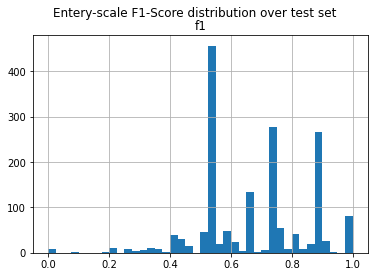

In [14]:
import pylab as pl

df.hist(column='f1',bins=40,sharey=True, sharex=True)
pl.suptitle('Entery-scale F1-Score distribution over test set')

### 15-Top worst

In [15]:
for i in range(0,150):
    print(f"INDEX {i}")
    print(df.iloc[i]["entry"])
    print(df.iloc[i]["entry_xml"])
    print(f"F1-Score : {df.iloc[i]['f1']}")
    print("")

INDEX 0
LDÉnudet "R. Phcvenot, 5.
<PER>LDÉnudet</PER> "<SPAT><LOC>R. Phcvenot</LOC>,<CARDINAL> 5</CARDINAL></SPAT>.
F1-Score : 0.0

INDEX 1
Quevin (charron), R. des Petites- Eurefi IRs
<PER>Quevin (</PER><ACT>charron</ACT><PER>),</PER><SPAT><LOC> R. des Petites- Eurefi IRs</LOC></SPAT>
F1-Score : 0.0

INDEX 2
VuRTNRupH, M deS:HIDNUS D
<PER>VuRT</PER>NR<PER>up</PER>H,<SPAT><LOC> M deS:HIDN</LOC></SPAT>US D
F1-Score : 0.0

INDEX 3
R H.  Horang cadel 25. Ghenet   du GFos- E "
R<SPAT><LOC> H.  Horang ca</LOC>del<CARDINAL> 25</CARDINAL></SPAT>.<SPAT><LOC> Ghenet   du GFos- E</LOC></SPAT> "
F1-Score : 0.0

INDEX 4
TOS  ☞OOLGJ†DOE 1* Penis g.o
TOS  ☞OOLGJ†DOE 1*<SPAT><LOC> Penis g</LOC></SPAT>.o
F1-Score : 0.0

INDEX 5
FiRion (H, pla ce des  compl Victoires  gétoff es
<PER>FiRion (H,</PER><ACT> pla ce</ACT><SPAT><LOC> des  compl Victoires  gétoff</LOC></SPAT> es
F1-Score : 0.0

INDEX 6
Aubert, (Mad.) pourtour du théâtre Franç.
<PER>Aubert,</PER><ACT> (</ACT><PER>M</PER><ACT>ad</ACT><PER>.)</P

### 15-Top best

In [16]:
rdf = df.sort_values(by='f1', ascending=False)
for i in range(0,16):
    print(rdf.iloc[i]["entry"])
    print(rdf.iloc[i]["entry_xml"])
    print(f"F1-Score : {rdf.iloc[i]['f1']}")
    print("")

Vigier (baronne de "Rivoli, 30
<PER>Vigier (baronne de</PER> "<SPAT><LOC>Rivoli</LOC>,<CARDINAL> 30</CARDINAL></SPAT>
F1-Score : 1.0

Valleville, rue Serv ndoni, 17.
<PER>Valleville</PER>,<SPAT><LOC> rue Serv ndoni</LOC>,<CARDINAL> 17</CARDINAL></SPAT>.
F1-Score : 1.0

Bouillac, r. d'Amboise, 9
<PER>Bouillac</PER>,<SPAT><LOC> r. d'Amboise</LOC>,<CARDINAL> 9</CARDINAL></SPAT>
F1-Score : 1.0

☞2 Duhamel, Bnufousa et comp. Rue S.  Dentiš ráh =
☞2<PER> Duhamel, Bnufousa et comp.</PER><SPAT><LOC> Rue S.  Dentiš</LOC> r<CARDINAL>áh</CARDINAL></SPAT> =
F1-Score : 1.0

Robert, R. Bergère, 19.
<PER>Robert</PER>,<SPAT><LOC> R. Bergère</LOC>,<CARDINAL> 19</CARDINAL></SPAT>.
F1-Score : 1.0

Béziade-Davaray, rue de Grenelle-Saint- Germain, 85.
<PER>Béziade-Davaray</PER>,<SPAT><LOC> rue de Grenelle-Saint- Germain</LOC>,<CARDINAL> 85</CARDINAL></SPAT>.
F1-Score : 1.0

Viguet (M.-L.) X, N.-D.-de-Lorette, 40.
<PER>Viguet (M.-L.)<TITREH> X</TITREH></PER>,<SPAT><LOC> N.-D.-de-Lorette</LOC>,<CARDINAL> 40<

## Sub-word global analysis

In [17]:
flat_preds = []
flat_labels = []
for i in range(len(df)):
    flat_preds += df["tags_preds"][i]
    flat_labels += df["tags_gold"][i]
flat_preds = pd.Series(flat_preds, name="Predictions")
flat_labels = pd.Series(flat_labels, name="Gold")

global_confusion = pd.crosstab(flat_labels, flat_preds,normalize='index').multiply(100., axis=1)
global_confusion.columns = ["ACT+O","DESC+O","DESC+ACT","DESC+TITREP","PER+O","PER+TITREH","SPAT+O","SPAT+CARD","SPAT+FT","SPAT+LOC","O+O"]
global_confusion.index = ["ACT+O","DESC+O","DESC+ACT","DESC+TITREP","PER+O","PER+TITREH","SPAT+O","SPAT+CARD","SPAT+FT","SPAT+LOC","O+O"]
global_confusion

,ACT+O,DESC+O,DESC+ACT,DESC+TITREP,PER+O,PER+TITREH,SPAT+O,SPAT+CARD,SPAT+FT,SPAT+LOC,O+O
ACT+O,89.796765,5.226047,3.131481,0.000000,0.580672,0.000000,0.041477,0.000000,0.041477,0.788055,0.394027
DESC+O,15.425940,44.973139,34.919417,0.690714,1.841903,0.000000,0.000000,0.000000,0.000000,1.688411,0.460476
DESC+ACT,19.205298,9.492274,71.302428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DESC+TITREP,0.000000,38.495575,4.424779,57.079646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PER+O,0.567802,0.434202,0.000000,0.000000,98.046092,0.033400,0.016700,0.016700,0.000000,0.200401,0.684703
PER+TITREH,0.000000,0.000000,0.000000,0.000000,1.333333,86.666667,0.000000,0.000000,0.000000,0.000000,12.000000
SPAT+O,0.000000,0.380022,0.000000,0.000000,0.000000,0.000000,95.114007,1.248643,0.000000,1.845820,1.411509
SPAT+CARD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382514,98.306011,0.000000,0.273224,1.038251
SPAT+FT,17.777778,31.111111,0.000000,0.000000,0.000000,0.000000,2.222222,4.444444,24.444444,0.000000,20.000000
SPAT+LOC,0.123693,0.179917,0.000000,0.000000,0.101203,0.000000,0.337344,0.033734,0.000000,99.055437,0.168672


Confusion matrix of reference and predicted tokens types.
Values are normalized by row (percentage of each reference classe and its resultants predictions)
Last row represent percentage of each class in gold.


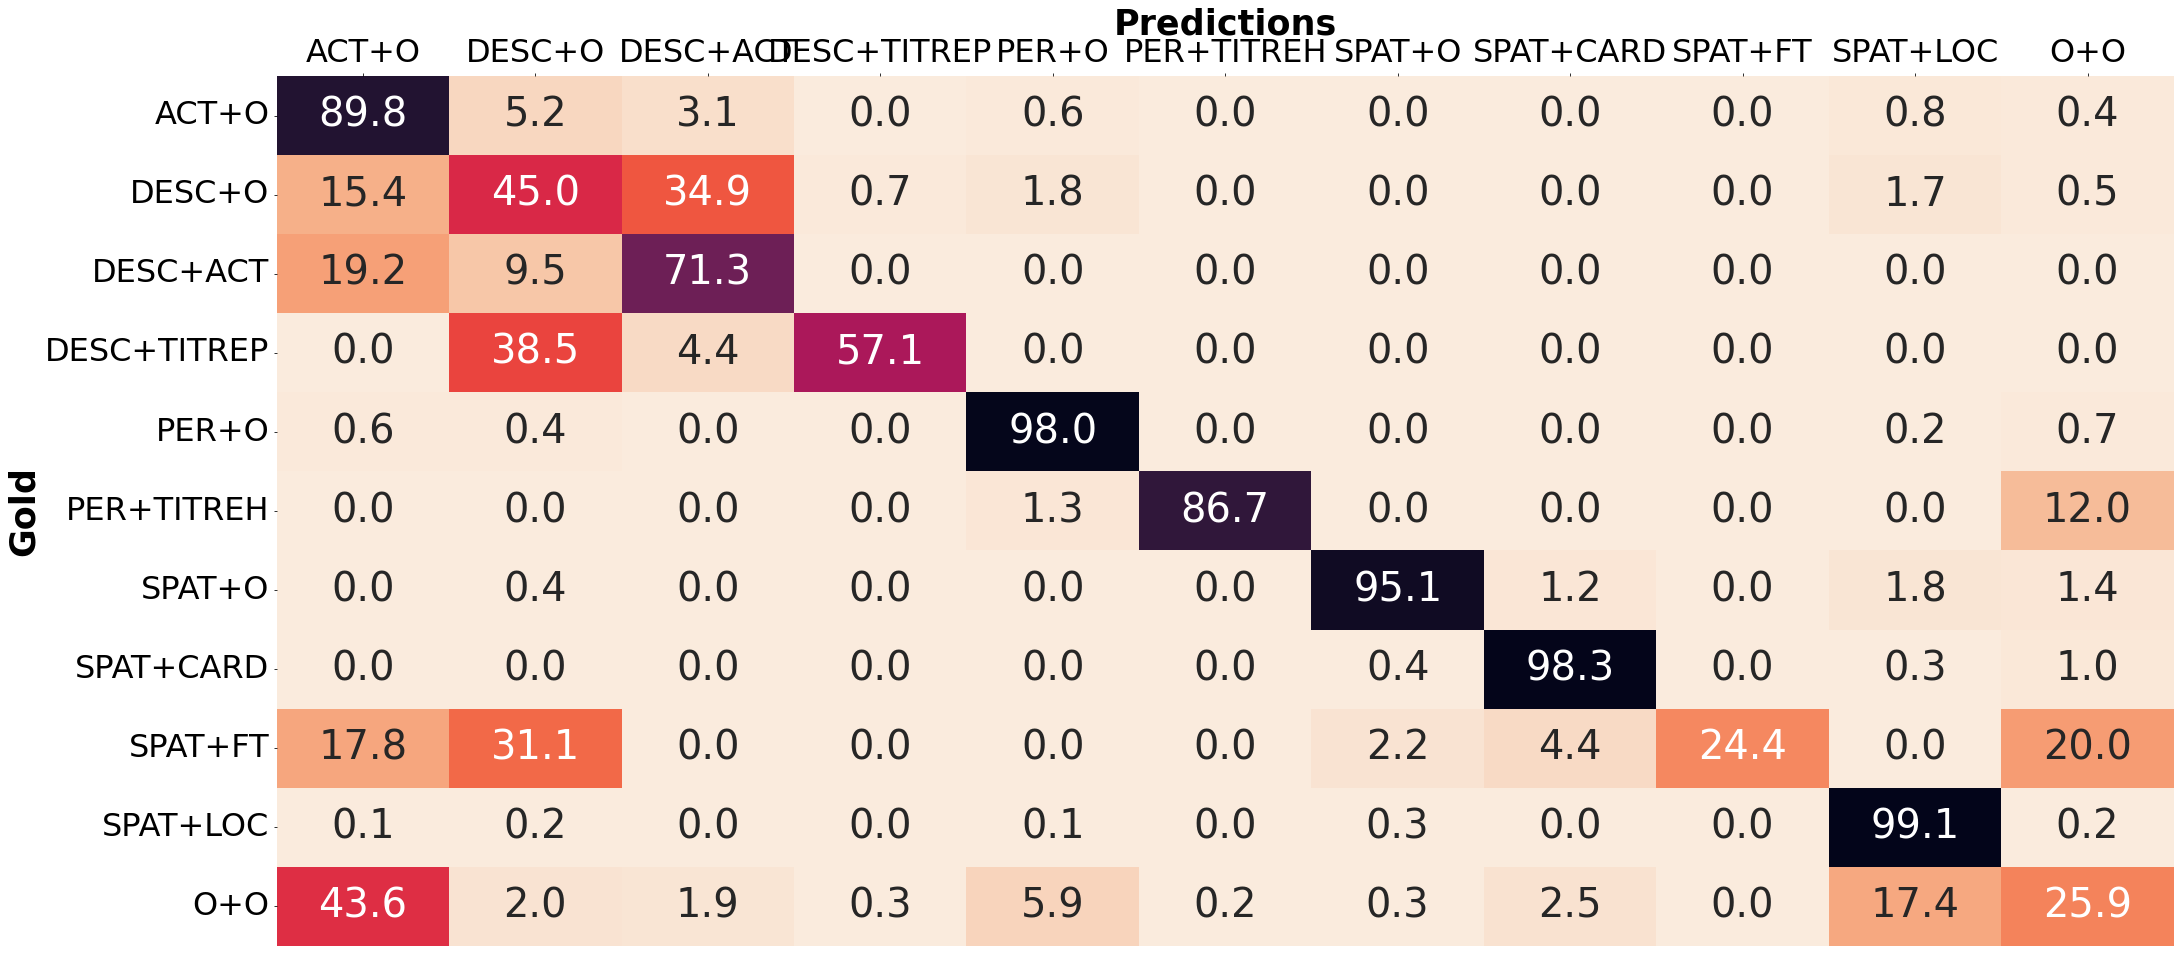

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Init figure
plt.figure(figsize=(34, 16))

#Create heatmap
snsfig = sns.heatmap(
    global_confusion, 
    annot = True, #Display labels
    cmap=sns.color_palette("rocket_r", as_cmap=True), #Color
    fmt=".1f",
    cbar=False,
    annot_kws={"fontsize":40}
)

#Rename label axis and set their style
plt.xlabel('Predictions',weight = 'bold',fontsize=35) # x-axis label with fontsize 15
plt.ylabel('Gold',weight = 'bold',fontsize=35) # y-axis label with fontsize 15

#Set x labels position to top
snsfig.xaxis.tick_top()
snsfig.xaxis.set_label_position('top')

#Rotate y ticks horizontaly
plt.yticks(rotation=0) 

#Change ticks size
snsfig.set_xticklabels(snsfig.get_xmajorticklabels(), fontsize = 32)
snsfig.set_yticklabels(snsfig.get_ymajorticklabels(), fontsize = 32)

print("Confusion matrix of reference and predicted tokens types.")
print("Values are normalized by row (percentage of each reference classe and its resultants predictions)")
print("Last row represent percentage of each class in gold.")

plt.show()

#Save figure
fig = snsfig.get_figure()
fig.tight_layout()
#fig.savefig(f"./tokenscaleanalysis-{FORMAT}-{SET}.pdf") 

## Entry scale analysis

Please choose one entry giving its index to perform an entry scale analysis :

In [19]:
i = 5

In [20]:
print(df.iloc[i]["entry"])
print(df.iloc[i]["entry_xml"])

FiRion (H, pla ce des  compl Victoires  gétoff es
<PER>FiRion (H,</PER><ACT> pla ce</ACT><SPAT><LOC> des  compl Victoires  gétoff</LOC></SPAT> es


In [21]:
from seqeval.metrics import classification_report

y_preds = df.iloc[i]["tags_preds"]
y_true = df.iloc[i]["tags_gold"]
print(classification_report([y_true],[y_preds]))

              precision    recall  f1-score   support

       ACT+O       0.00      0.00      0.00         1
       PER+O       0.00      0.00      0.00         1
  SPAT+i_LOC       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         3
   macro avg       0.00      0.00      0.00         3
weighted avg       0.00      0.00      0.00         3



/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: O+O seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_true = pd.Series(df["tags_gold"].iloc[i], name='Gold')
y_pred = pd.Series(df["tags_preds"].iloc[i], name='Predictions')
entry_confusion = pd.crosstab(y_true, y_pred)
entry_confusion

Predictions,I-ACT+O,I-PER+O,I-SPAT+i_LOC,O+O
Gold,,,,
I-ACT+O,0,0,1,0
I-PER+O,2,6,0,0
I-SPAT+i_LOC,0,0,3,0
O+O,0,0,3,1


Confusion matrix of reference and predicted tokens types.


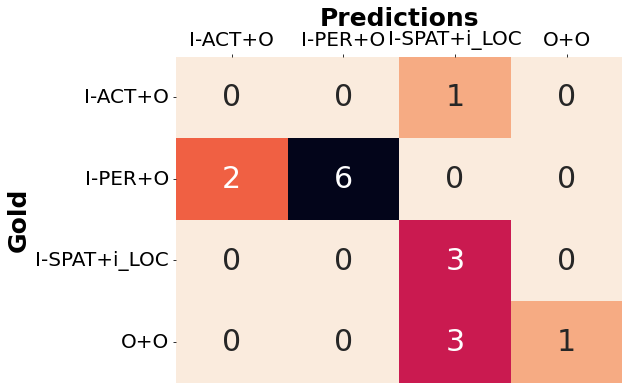

In [23]:
plt.figure(figsize=(8, 6))

#Create heatmap
snsfig = sns.heatmap(
    entry_confusion, 
    annot = True, #Display labels
    cmap=sns.color_palette("rocket_r", as_cmap=True), #Color
    fmt="g",
    cbar=False,
    annot_kws={"fontsize":30}
)

#Rename label axis and set their style
plt.xlabel('Predictions',weight = 'bold',fontsize=25) # x-axis label with fontsize 15
plt.ylabel('Gold',weight = 'bold',fontsize=25) # y-axis label with fontsize 15

#Set x labels position to top
snsfig.xaxis.tick_top()
snsfig.xaxis.set_label_position('top')

#Rotate y ticks horizontaly
plt.yticks(rotation=0) 

#Change ticks size
snsfig.set_xticklabels(snsfig.get_xmajorticklabels(), fontsize = 20)
snsfig.set_yticklabels(snsfig.get_ymajorticklabels(), fontsize = 20)

print("Confusion matrix of reference and predicted tokens types.")

plt.show()

#Save figure
fig = snsfig.get_figure()